<a href="https://colab.research.google.com/github/yohanesnuwara/MRST-simulations/blob/master/MRST_inside_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install octave in Google Colab. Takes ~2 mins

In [1]:
!apt install octave

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aglfn epstool fonts-droid-fallback fonts-noto-mono ghostscript gnuplot-data
  gnuplot-qt gsfonts imagemagick-6-common info install-info libamd2
  libauthen-sasl-perl libcamd2 libccolamd2 libcholmod3 libcolamd2
  libcupsfilters1 libcupsimage2 libcxsparse3 libdata-dump-perl libemf1
  libencode-locale-perl libfftw3-single3 libfile-listing-perl libfltk-gl1.3
  libfltk1.3 libfont-afm-perl libgail-common libgail18 libglpk40
  libgraphicsmagick++-q16-12 libgraphicsmagick-q16-3 libgs9 libgs9-common
  libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libhtml-form-perl
  libhtml-format-perl libhtml-parser-perl libhtml-tagset-perl
  libhtml-tree-perl libhttp-cookies-perl libhttp-daemon-perl libhttp-date-perl
  libhttp-message-perl libhttp-negotiate-perl libijs-0.35 libio-html-perl
  libio-socket-ssl-perl libjbig2dec0 liblqr-1-0 liblua5.3-0
  liblwp-mediat

## Running Optimization of a Matlab Function using Optimizers in Python

In [146]:
import numpy as np
import matplotlib.pyplot as plt

!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

In [138]:
%%writefile obj.m
function z = obj(x,y)
z = 0.9 * exp(-((x - 0.5) / 0.5)^2 - ((y - 0.5) / 0.5)^2);
z = z + exp(-((x + 0.2) / 0.5)^2 - ((y + 0.2) / 0.5)^2); 
z = z + log1p(x*y*x*y);
end

Overwriting obj.m


In [139]:
%%writefile implement_obj.m
addpath '/content' % to obtain objective function

# read input from input.txt
fileID = fopen('input.txt','r');
formatSpec = '%f';
P = fscanf(fileID,formatSpec);
x = P(1); 
y = P(2);

display(obj(x,y))

Overwriting implement_obj.m


In [141]:
def shadow_objective(x, y):
  """
  Shadowing an objective function in Matlab to be called with Python
  
  Works by converting (x,y) input into input.txt file, then
  run the Matlab file "implement.m" to extract the input.txt
  and internally compute with the Matlab objective function "obj" 
  """

  # convert (x,y) input into input text file
  input = [x, y]
  np.savetxt('input.txt', input)

  # execute matlab based on inputs given 
  z = !octave -W implement_obj.m

  # output is a string. Convert output to numpy float
  z = np.float64(z)[0]

  return z

In [143]:
# execute the objective function
shadow_objective(0.2022, 0.4161)

0.73546

In [144]:
# Bounded region of parameter space
pbounds = {"x": (-1, 1), "y": (-1, 1)}

optimizer = BayesianOptimization(
    f=shadow_objective, # it is a Python obj. func. that carries a Matlab obj. func.
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(init_points=5, n_iter=20)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        |  0.1071   | -0.2509   |  0.9014   |
|  2        |  0.7202   |  0.464    |  0.1973   |
|  3        |  0.351    | -0.688    | -0.688    |
|  4        |  0.355    | -0.8838   |  0.7324   |
|  5        |  0.7355   |  0.2022   |  0.4161   |
|  6        |  0.6934   |  1.0      | -1.0      |
|  7        |  0.815    |  1.0      |  1.0      |
|  8        |  0.07783  |  0.1909   | -1.0      |
|  9        |  0.06808  | -1.0      | -0.01803  |
|  10       |  0.382    |  1.0      |  0.3126   |
|  11       |  0.6991   | -1.0      | -1.0      |
|  12       |  0.5812   |  0.5346   |  1.0      |
|  13       |  0.2218   |  1.0      | -0.487    |
|  14       |  0.8894   | -0.03191  | -0.0291   |
|  15       |  0.6062   | -0.2889   |  0.1732   |
|  16       |  0.5793   |  0.2203   | -0.2169   |
|  17       |  0.6736   | -0.9859   |  0.9942   |
|  18       |  0.7268   |  0.1022   |  0.1264   |


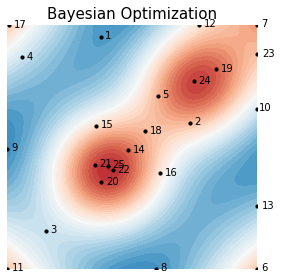

In [152]:
# -------------------------
# Plot the function
# -------------------------
N = 32
n = 2 ** 7
x = np.linspace(-1, 1, n)
y = np.linspace(-1, 1, n)
x, y = np.meshgrid(x, y)
z = black_box_function(x, y)

# z = []
# for i in range(len(x)):
#   _ = shadow_objective(x[i], y[i])
#   z.append(_)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Bayesian Optimization", fontsize=15)
# ax.contour(x, y, z, N, linewidths=0.8, colors='k')
ax.contourf(x, y, z, N, cmap="RdBu_r", vmin=-0.2, vmax=1.2)
plt.xticks([])
plt.yticks([])

# -------------------------
# Plot points
# -------------------------
# https://github.com/fmfn/BayesianOptimization/blob/master/examples/basic-tour.ipynb

for i, res in enumerate(optimizer.res):
    plt.scatter(res["params"]["x"], res["params"]["y"], color="k", s=10)
    plt.text(
        res["params"]["x"] + 0.03 + 0.03 * len(str(i)),
        res["params"]["y"] + 0.01,
        str(i + 1),
        size=10,
        rotation=0.0,
        ha="center",
        va="center",
    )

ax.axis("off")
plt.tight_layout()
#plt.savefig("bayes_opt.pdf")
plt.show()

## MRST

In [2]:
!git clone https://github.com/yohanesnuwara/MRST-simulations

Cloning into 'MRST-simulations'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 173 (delta 6), reused 0 (delta 0), pack-reused 153
Receiving objects: 100% (173/173), 27.72 MiB | 23.40 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [3]:
!git clone https://github.com/yohanesnuwara/reservoir_datasets

Cloning into 'reservoir_datasets'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 189 (delta 22), reused 67 (delta 20), pack-reused 120
Receiving objects: 100% (189/189), 97.03 MiB | 22.15 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Checking out files: 100% (138/138), done.


In [4]:
!git clone https://bitbucket.org/mrst/mrst-core.git

Cloning into 'mrst-core'...
remote: Counting objects: 8934, done.
remote: Compressing objects: 100% (4594/4594), done.
remote: Total 8934 (delta 6763), reused 6247 (delta 4254)
Receiving objects: 100% (8934/8934), 5.71 MiB | 16.37 MiB/s, done.
Resolving deltas: 100% (6763/6763), done.


In [5]:
!git clone https://yohanesnuwara@bitbucket.org/mrst/mrst-autodiff.git

Cloning into 'mrst-autodiff'...
remote: Counting objects: 40863, done.
remote: Compressing objects: 100% (12732/12732), done.
remote: Total 40863 (delta 29923), reused 37400 (delta 27804)
Receiving objects: 100% (40863/40863), 15.26 MiB | 25.70 MiB/s, done.
Resolving deltas: 100% (29923/29923), done.


## Compute Lorenz SPE10

### Overwriting, writing files, and modifying directories

#### Main program

In [70]:
%%writefile /content/MRST-simulations/simulations/computeLorenzSPE10.m
%% Lorenz coefficient for layers of SPE 10, Model 2
% In this example, we first compute the Lorenz coefficient for all layers
% of the SPE10 model subject to a five-spot well pattern. We then pick one
% of the layers and show how we can balance the well allocation and improve
% the Lorenz coefficient and the areal sweep by moving some of the wells to
% regions with better sand quality.
%mrstModule add diagnostics spe10 incomp

addpath '/content/mrst-core/utils/units'
addpath '/content/mrst-core/gridprocessing'
addpath '/content/mrst-core/modules'
addpath '/content/mrst-core/params/wells_and_bc'
addpath '/content/mrst-core/solvers'

%% Base model
% We set up a grid. Later, we will assign petrophysical properties from one
% single layer at the time to compute Lorenz coefficients inside the main
% loop
cartDims = [  60,  220,  1];
physDims = [1200, 2200, 2*cartDims(end)] .* ft();
G  = cartGrid(cartDims, physDims);
G  = computeGeometry(G);

% Set parameters describing the 
wtype    = {'bhp', 'bhp', 'bhp', 'bhp', 'bhp'};
wtarget  = [200,   200,   200,   200,   500] .* barsa();
wrad     = [0.125, 0.125, 0.125, 0.125, 0.125] .* meter;
wloc     = [  1,   60,     1,   60,  30;
              1,    1,   220,  220, 111];
wname    = {'P1', 'P2', 'P3', 'P4', 'I'};

% Set fluid model: Here, we use a simple fluid model with properties that
% are typical for water. Replace this by a multiphase fluid object if you
% also want to include fluid effects in the calculation
fluid = initSingleFluid('mu', 1*centi*poise, ...
                        'rho', 1014*kilogram/meter^3);

%% Compute Lorenz coefficient for each layer
Lc = zeros(85,1);

for n=1:85
    
    % --- Set petrophysical data for this particular layer
    % To avoid problems with very small porosity values, we explicitly
    % impose a lower threshold of 1e-4
    rock = getSPE10rock(1:cartDims(1),1:cartDims(2),n);
    rock.poro = max(rock.poro, 1e-4);
    
    % --- Set up well model
    % To ensure that we get the correct well index when updating the
    % petrophysical data, we simply regenerate the well objects.
    W = [];
    for w = 1 : numel(wtype)
        W = verticalWell(W, G, rock, wloc(1,w), wloc(2,w), 1, ...
            'Type', wtype{w}, 'Val', wtarget(w), ...
            'Radius', wrad(w), 'Name', wname{w}, ...
            'InnerProduct', 'ip_tpf', 'Comp_i', 1);
    end
    
    % --- Initiate and solve flow problem 
    rS = initState(G, W, 0, 0.0);
    T  = computeTrans(G, rock);
    rS = incompTPFA(rS, G, T, fluid, 'wells', W);
    
    % --- Compute flow diagnostics
    D       = computeTOFandTracer(rS, G, rock, 'wells', W, 'maxTOF', inf);
    [F,Phi] = computeFandPhi(poreVolume(G,rock), D.tof);
    Lc(n)   = computeLorenz(F,Phi);
    [Ev,tD] = computeSweep(F, Phi);

end

%% Produce the results
display(Lc) % Lorenz coefficient each layer
display(F)  % F and Phi are Lorenz parameters
display(Phi)
display(Ev) % Ev and tD are sweep parameters
display(tD)


%{
%% Improve Lorenz/sweep by moving wells
% Here, we have first computed Lorenz coefficient, sweep and well-pair
% connections for the layer with lowest/highest Lorenz coefficient and then
% tried to move the wells having small allocation factors to the nearest
% high-poro region that seems reasonably well connected with the injector. 
minCase = false;  %#ok<*UNRCH>
if minCase
    [~,n]=min(Lc);
else
    [~,n]=max(Lc);                                                         
end
rock = getSPE10rock(1:cartDims(1),1:cartDims(2),n);
rock.poro = max(rock.poro, 1e-4);
pv = poreVolume(G, rock);

nwloc = wloc;
fig1=figure('Position',[250 490 750 300]); col = {'b','g'};
for nstep=1:2
    % Set well conditions
    W = [];
    for w = 1 : numel(wtype)
        W = verticalWell(W, G, rock, nwloc(1,w), nwloc(2,w), 1, ...
            'Type', wtype{w}, 'Val', wtarget(w), ...
            'Radius', wrad(w), 'Name', wname{w}, ...
            'InnerProduct', 'ip_tpf');
    end

    % Compute flow field and diagnostics
    rS = initState(G, W, 0);
    T  = computeTrans(G, rock);
    rS = incompTPFA(rS, G, T, fluid, 'wells', W);
    D  = computeTOFandTracer(rS, G, rock, 'wells', W, 'maxTOF', inf);
    WP = computeWellPairs(rS, G, rock, W, D);
    [F,Phi] = computeFandPhi(pv, D.tof);
    computeLorenz(F,Phi)
    [Ev,tD] = computeSweep(F, Phi);

    % Plot F-Phi and sweep diagram
    % To reduce the number of points, we resample the data
    figure(fig1);
    subplot(1,2,1); hold on; 
    xq = linspace(0,1,100);
    vq = interp1(Phi,F,xq);
    plot(xq,vq,['-',col{nstep}],'LineWidth',2); hold off;
    
    subplot(1,2,2); hold on;
    [T,ia] = unique(tD);
    E = Ev(ia);
    xq = linspace(0,5+(1-minCase)*20,100);
    vq = interp1(T,E,xq);
    plot(xq,vq,['-',col{nstep}],'LineWidth',2); hold off;
    
    % Plot porosity map and well-pair connections
    figure('Position',[710   420   720   400]);
    plotCellData(G,rock.poro,'EdgeColor','none');
    plotWell(G,W,'height',10,'LineWidth',4);
    plotWellPairConnections(G,WP,D,W,pv,1e-4);
    cmap=jet(128); colormap(.4*cmap + .6*ones(size(cmap))); clear cmap;
    view(0,70); set(gca,'DataAspectRatio',[1 1 .5]); axis off
    cax = caxis;

    % Plot zoom around each producer in separate axes
    pos = [.05 .05 .25 .35;  .725 .05 .25 .35; ...
        .05 .6 .25 .35; .725 .6 .25 .35];
    for i=1:4
        axes('position', pos(i,:));
        if nstep==1
            rad(:,i) = sum(bsxfun(@minus,G.cells.centroids,....
                G.cells.centroids(W(i).cells,:)).^2,2); %#ok<SAGROW>
        end
        plotCellData(G,rock.poro,rad(:,i)<3500,'EdgeColor','k','EdgeAlpha',.1);
        plotWell(G,W(i),'height',10,'LineWidth',10);
        caxis(cax);
        view(0,70); set(gca,'DataAspectRatio',[1 1 .5]); axis off tight;
    end
    
    % Impose manually improved well positions for next pass
    if minCase
        nwloc     = [  1,   53,     1,   59,  30;
                       1,    2,   218,  220, 111];
    else
        nwloc     = [  1,   60,     7,   60,  30;
                       6,   11,   220,  219, 111];
    end
    vertcat(rS.wellSol.flux)
end
figure(fig1);
subplot(1,2,1); hold on; plot([0 1],[0 1],'k'); hold off; title('Lorenz');
subplot(1,2,2); set(gca,'XLim',[0 5+(1-minCase)*20]); title('Sweep');
%}

Overwriting /content/MRST-simulations/simulations/computeLorenzSPE10.m


#### Functions

In [7]:
%%writefile /content/mrst-core/gridprocessing/tensorGrid.m
function G = tensorGrid(x, varargin)
%Construct Cartesian grid with variable physical cell sizes.
%
% SYNOPSIS:
%   G = tensorGrid(x)
%   G = tensorGrid(x, y)
%   G = tensorGrid(x, y, 'depthz', dz)
%   G = tensorGrid(x, y, z)
%   G = tensorGrid(x, y, z, 'depthz', dz)
%
% PARAMETERS:
%   x,y,z    - Vectors giving cell vertices, in units of meters, of individual
%              coordinate directions.  Specifically, the grid cell at
%              logical location (I,J,K) will have a physical dimension of
%              [x(I+1)-x(I), y(J+1)-y(J), z(K+1)-z(K)] (meters).
%
%   dz       - Depth, in units of meters, at which upper reservoir nodes
%              are encountered.  Assumed to be a
%              NUMEL(x)-by-NUMEL(y) array of nodal depths.
%
%              OPTIONAL.
%              Default value: depthz = ZEROS([numel(x), numel(y)])
%                             (i.e., top of reservoir at zero depth).
%
%   cellnodes- OPTIONAL.
%              Default value FALSE.  If TRUE, the corner points of each
%              cell is added as field G.cellNodes.  The field has one row
%              per cell, the sequence of nodes on each is (imin,
%              jmin,kmin), (imax,jmin,kmin), (imin,jmax,kmin), ...
%
% RETURNS:
%   G - Grid structure with a subset of the fields `grid_structure`.
%       Specifically, the geometry fields are missing:
%         - G.cells.volumes
%         - G.cells.centroids
%
%         - G.faces.areas
%         - G.faces.normals
%         - G.faces.centroids
%
%       These fields may be computed using the function `computeGeometry`.
%
%       There is, however, an additional field not described in
%       `grid_structure:
%
%           `cartDims` is a length 1, 2 or 3 vector giving number of cells
%           in each coordinate direction.  In other words 
%
%                      `all(G.cartDims == celldim)`.
%
%       `G.cells.faces(:,2)` contains integers 1-6 corresponding to
%       directions W, E, S, N, T, B respectively.
%
%
% SEE ALSO:
%   `grid_structure`, `computeGeometry`

%{
Copyright 2009-2020 SINTEF Digital, Mathematics & Cybernetics.

This file is part of The MATLAB Reservoir Simulation Toolbox (MRST).

MRST is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

MRST is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with MRST.  If not, see <http://www.gnu.org/licenses/>.
%}

   % Find first char option
   firstOpt = find(cellfun(@ischar, varargin), 1, 'first');
   dim = nargin();
   if ~isempty(firstOpt)
       % If option N is char, then the dimension is N-1 since the first N-1
       % entries correspond to coordinates. Note that there is an
       % off-by-one offset here since we always assume at least one
       % coordinate is given.
       dim = firstOpt;
   end

   switch dim
       case 1
           G = tensorGrid1D(x, varargin{:});
       case 2
           G = tensorGrid2D(x, varargin{:});
       case 3
           G = tensorGrid3D(x, varargin{:});
       otherwise
           error('Invalid grid dimension "%d"', dim);
   end

   % Record grid constructor in grid.
   G.type    = { mfilename };
   G.griddim = numel(G.cartDims);
end

function G = tensorGrid3D(x, y, z, varargin)
   addpath '/content/mrst-core/utils'
   mrstNargInCheck(3, 5, nargin);

   %-----------------------------------------------------------------------
   % Check input data -----------------------------------------------------
   x = x(:); dx=diff(x);
   if ~all(dx > 0)
      warning('tensorGrid:xData', 'Nonmonotone x-data, truncating..');
      while ~all(dx>0)
         i = find(dx>0); x = x([1; i+1]); dx = diff(x);
      end
   end
   y=y(:); dy = diff(y);
   if ~all(dy > 0)
      warning('tensorGrid:yData', 'Nonmonotone y-data, truncating..');
      while ~all(dy>0)
         i = find(dy>0); y = y([1; i+1]); dy = diff(y);
      end
   end
   z=z(:); dz = diff(z);
   if ~all(dz > 0)
      warning('tensorGrid:yData', 'Nonmonotone z-data, truncating..');
      while ~all(dz>0)
         i = find(dz>0); z = z([1; i+1]); dz = diff(z);
      end
   end

   sx = numel(x)-1; sy = numel(y)-1; sz = numel(z)-1;
   celldim = [sx, sy, sz];

   opt = struct('depthz', zeros(sx+1, sy+1), 'cellnodes', false);
   opt = merge_options(opt, varargin{:});
   if numel(opt.depthz) ~= (sx+1) * (sy+1)
      error(msgid('DepthZ:WrongSize'), ...
         'Input argument ''depthz'' is wrongly sized.')
   end

   numC = sx * sy * sz;             % Number of cells.
   numN = (sx+1) * (sy+1) * (sz+1); % Number of nodes.

   numFX = (sx+1) * sy * sz;        % Number of faces parallel to yz-plane.
   numFY = sx * (sy+1) * sz;        % Number of faces parallel to xz-plane.
   numFZ = sx * sy * (sz+1);        % Number of faces parallel to xy-plane.
   numF  = numFX + numFY + numFZ;

   %--------------------------------------------------------------------------
   % Nodes/Coordinates -------------------------------------------------------

   [xCoord, yCoord, zCoord] = ndgrid(x, y, z);

   zCoord = bsxfun(@plus, zCoord, reshape(opt.depthz, [sx, sy] + 1));

   coords = [xCoord(:), yCoord(:), zCoord(:)];

   %--------------------------------------------------------------------------
   % Generate face-edges ----------------------------------------------------

   % Node index matrix
   N = reshape(1 : numN, [sx+1, sy+1, sz+1]);

   %--------------------------------------------------------------------------
   % x-faces -----------------------------------------------------------------
   %
   NF1 = reshape(N(1:sx+1, 1:sy  , 1:sz  ), 1, []);
   NF2 = reshape(N(1:sx+1, 2:sy+1, 1:sz  ), 1, []);
   NF3 = reshape(N(1:sx+1, 2:sy+1, 2:sz+1), 1, []);
   NF4 = reshape(N(1:sx+1, 1:sy  , 2:sz+1), 1, []);

   faceNodesX = reshape([NF1; NF2; NF3; NF4], [], 1);

   %--------------------------------------------------------------------------
   % y-faces -----------------------------------------------------------------
   %
   NF1 = reshape(N(1:sx  , 1:sy+1, 1:sz  ), 1, []);
   NF2 = reshape(N(1:sx  , 1:sy+1, 2:sz+1), 1, []);
   NF3 = reshape(N(2:sx+1, 1:sy+1, 2:sz+1), 1, []);
   NF4 = reshape(N(2:sx+1, 1:sy+1, 1:sz  ), 1, []);

   faceNodesY = reshape([NF1; NF2; NF3; NF4], [], 1);

   %--------------------------------------------------------------------------
   % z-faces -----------------------------------------------------------------
   %
   NF1 = reshape(N(1:sx  , 1:sy,   1:sz+1), 1, []);
   NF2 = reshape(N(2:sx+1, 1:sy,   1:sz+1), 1, []);
   NF3 = reshape(N(2:sx+1, 2:sy+1, 1:sz+1), 1, []);
   NF4 = reshape(N(1:sx  , 2:sy+1, 1:sz+1), 1, []);

   faceNodesZ = reshape([NF1; NF2; NF3; NF4], [], 1);

   %--------------------------------------------------------------------------
   % Assemble grid_structure faceNodes structure -----------------------------
   %
   faceNodes = [faceNodesX; ...
      faceNodesY; ...
      faceNodesZ];

   clear -regexp ^faceNodes. ^N ^NF.
   %--------------------------------------------------------------------------
   % Generate cell-faces ----------------------------------------------------

   foffset = 0;
   % Face index matrices
   FX = reshape(foffset + (1:numFX), sx+1, sy  , sz  ); foffset = foffset + numFX;
   FY = reshape(foffset + (1:numFY), sx  , sy+1, sz  ); foffset = foffset + numFY;
   FZ = reshape(foffset + (1:numFZ), sx  , sy  , sz+1);

   F1 = reshape(FX(1:sx  , :, :), 1, []); %W == 1
   F2 = reshape(FX(2:sx+1, :, :), 1, []); %E == 2

   F3 = reshape(FY(:, 1:sy  , :), 1, []); %S == 3
   F4 = reshape(FY(:, 2:sy+1, :), 1, []); %N == 4

   F5 = reshape(FZ(:, :, 1:sz  ), 1, []); %T == 5
   F6 = reshape(FZ(:, :, 2:sz+1), 1, []); %B == 6

   cellFaces = [reshape([F1; F2; F3; F4; F5; F6], [], 1), ...
      kron(ones([numC, 1]), [ 1, 2, 3, 4, 5, 6]')];

   clear -regexp ^F.

   %--------------------------------------------------------------------------
   % Generate neighbors -----------------------------------------------------

   % Cell index matrix
   C = zeros([sx+2, sy+2, sz+2]);
   C(2:sx+1, 2:sy+1, 2:sz+1) = reshape(1:numC, [sx, sy, sz]);

   NX1 = reshape(C( 1:sx+1, 2:sy+1, 2:sz+1), [], 1);
   NX2 = reshape(C( 2:sx+2, 2:sy+1, 2:sz+1), [], 1);

   NY1 = reshape(C( 2:sx+1, 1:sy+1, 2:sz+1), [], 1);
   NY2 = reshape(C( 2:sx+1, 2:sy+2, 2:sz+1), [], 1);

   NZ1 = reshape(C( 2:sx+1, 2:sy+1, 1:sz+1), [], 1);
   NZ2 = reshape(C( 2:sx+1, 2:sy+1, 2:sz+2), [], 1);

   neighbors = [ [NX1, NX2]; ...
      [NY1, NY2]; ...
      [NZ1, NZ2] ];

   clear -regexp ^N..

   %-----------------------------------------------------------------------
   % Generate cell nodes -------------------------------------------------
   if opt.cellnodes
      % Index to first node in each cell
      k  = firstnodeindex([sx+1, sy+1, sz+1], 1:sx, 1:sy, 1:sz);
      di = 1;
      dj = sx+1;
      dk = (sx+1)*(sy+1);
      cNodes = [k, k+di, k+dj, k+di+dj, k+dk, k+di+dk, k+dj+dk, k+di+dj+dk];
   end
   %--------------------------------------------------------------------------
   % Assemble structure -----------------------------------------------------

   G.cells = struct('num',      numC,                   ...
                    'facePos',  (1:6:(numC+1)*6)', ...
                    'indexMap', (1 : numC)');

   G.faces = struct('num',       numF,                   ...
                    'nodePos',   (1:4:(numF+1)*4)', ...
                    'neighbors', (neighbors),       ...
                    'tag',       zeros(numF, 1));

   G.nodes = struct('num', numN, 'coords', coords);

   G.cells.faces = cellFaces;
   G.faces.nodes = faceNodes;
   if opt.cellnodes
      G.cellNodes = cNodes;
   end
   G.cartDims = celldim;
end


function G = tensorGrid2D(x, y, varargin)
   mrstNargInCheck(2, 4, nargin);
   opt = struct('cellnodes', false);
   opt = merge_options(opt, varargin{:});

   %-----------------------------------------------------------------------
   % Check input data -----------------------------------------------------
   x = x(:); dx=diff(x);
   if ~all(dx > 0)
      warning('tensorGrid:xData', 'Nonmonotone x-data, truncating..');
      while ~all(dx>0)
         i = find(dx>0); x = x([1; i+1]); dx = diff(x);
      end
   end
   y=y(:); dy = diff(y);
   if ~all(dy > 0)
      warning('tensorGrid:yData', 'Nonmonotone y-data, truncating..');
      while ~all(dy>0)
         i = find(dy>0); y = y([1; i+1]); dy = diff(y);
      end
   end

   sx = numel(x)-1; sy = numel(y)-1;
   celldim = [sx, sy];

   numC = sx * sy;             % Number of cells.
   numN = (sx+1) * (sy+1);     % Number of nodes.s

   numFX = (sx+1) * sy;        % Number of faces parallel to y-axis.
   numFY = sx * (sy+1);        % Number of faces parallel to x-axis.
   numF  = numFX + numFY;

   %-----------------------------------------------------------------------
   % Nodes/Coordinates ----------------------------------------------------

   [xCoord, yCoord] = ndgrid(x, y);
   coords = [xCoord(:), yCoord(:)];

   %-----------------------------------------------------------------------
   % Generate face-edges --------------------------------------------------

   % Node index matrix
   N = reshape(1 : numN, [sx+1, sy+1]);

   %-----------------------------------------------------------------------
   % x-faces --------------------------------------------------------------
   %
   NF1 = reshape(N(1:sx+1, 1:sy  ), 1, []);
   NF2 = reshape(N(1:sx+1, 2:sy+1), 1, []);

   faceNodesX = reshape([NF1; NF2], [], 1);

   %-----------------------------------------------------------------------
   % y-faces --------------------------------------------------------------
   %
   NF1 = reshape(N(1:sx  , 1:sy+1), 1, []);
   NF2 = reshape(N(2:sx+1, 1:sy+1), 1, []);

   faceNodesY = reshape([NF2; NF1], [], 1);
   % Note:
   % Nodes need to be reversed to obtain normals
   % pointing in positive i-direction in computeGeometry.

   %-----------------------------------------------------------------------
   % Assemble grid_structure faceNodes structure --------------------------
   %
   faceNodes = [faceNodesX; ...
                faceNodesY];

   clear -regexp ^faceNodes. ^N ^NF.
   %-----------------------------------------------------------------------
   % Generate cell-faces --------------------------------------------------

   foffset = 0;
   % Face index matrices
   FX = reshape(foffset + (1:numFX), sx+1, sy  ); foffset = foffset + numFX;
   FY = reshape(foffset + (1:numFY), sx  , sy+1);

   F1 = reshape(FX(1:sx  , :), 1, []); %W == 1
   F2 = reshape(FX(2:sx+1, :), 1, []); %E == 2

   F3 = reshape(FY(:, 1:sy  ), 1, []); %S == 3
   F4 = reshape(FY(:, 2:sy+1), 1, []); %N == 4

   cellFaces = [reshape([F1; F3; F2; F4], [], 1), ...
                kron(ones([numC, 1]), [ 1, 3, 2, 4]')];

   clear -regexp ^F.

   %-----------------------------------------------------------------------
   % Generate neighbors ---------------------------------------------------

   % Cell index matrix
   C = zeros([sx+2, sy+2]);
   C(2:sx+1, 2:sy+1) = reshape(1:numC, [sx, sy]);

   NX1 = reshape(C( 1:sx+1, 2:sy+1), [], 1);
   NX2 = reshape(C( 2:sx+2, 2:sy+1), [], 1);

   NY1 = reshape(C( 2:sx+1, 1:sy+1), [], 1);
   NY2 = reshape(C( 2:sx+1, 2:sy+2), [], 1);

   neighbors = [[NX1, NX2]; [NY1, NY2]];

   clear -regexp ^N..

   %-----------------------------------------------------------------------
   % Generate cell nodes --------------------------------------------------
   if opt.cellnodes
      % Index to first node in each cell
      k  = firstnodeindex([sx+1, sy+1], 1:sx, 1:sy);
      di = 1;
      dj = sx+1;
      cNodes = [k, k+di, k+dj, k+di+dj];
   end
   %-----------------------------------------------------------------------
   % Assemble structure ---------------------------------------------------

   G.cells = struct('num',      numC,                   ...
                    'facePos',  (1:4:(numC+1)*4)', ...
                    'indexMap', (1 : numC)');

   G.faces = struct('num',       numF,                   ...
                    'nodePos',   (1:2:(numF+1)*2)', ...
                    'neighbors', neighbors,       ...
                    'tag',       zeros(numF, 1));

   G.nodes = struct('num', numN, 'coords', coords);

   G.cells.faces = cellFaces;
   G.faces.nodes = faceNodes;
   if opt.cellnodes
      G.cellNodes = cNodes;
   end
   G.cartDims = celldim;
end

function G = tensorGrid1D(x, varargin)
   mrstNargInCheck(1, 3, nargin);
   opt = struct('cellnodes', false);
   opt = merge_options(opt, varargin{:});

   %-----------------------------------------------------------------------
   % Check input data -----------------------------------------------------
   x = x(:); dx=diff(x);
   if ~all(dx > 0)
      warning('tensorGrid:xData', 'Nonmonotone x-data, truncating..');
      while ~all(dx>0)
         i = find(dx>0); x = x([1; i+1]); dx = diff(x);
      end
   end
   sx = numel(x)-1;
   celldim = sx;

   numC = sx;         % Number of cells.
   numN = (sx+1);     % Number of nodes.
   numF = numN;       % Number of faces.

   %-----------------------------------------------------------------------
   % Nodes/Coordinates ----------------------------------------------------

   coords = x;
   v = (0:numC)';
   neighbors = [v, circshift(v, -1)];

   G.cells = struct('num',      numC,                   ...
                    'facePos',  (1:2:(numC+1)*2)', ...
                    'indexMap', (1 : numC)');

   G.faces = struct('num',       numF,                   ...
                    'nodePos',   (1:numF+1)', ...
                    'neighbors', neighbors,       ...
                    'tag',       zeros(numF, 1));

   G.nodes = struct('num', numN, 'coords', coords);

   cellFaces = [1; reshape(repmat(2:numC, 2, 1), [], 1); numC+1];
   cellFaceTag = repmat([1; 2], numC, 1);
   % Faces are equal to nodes for this type of grid
   G.cells.faces = [cellFaces, cellFaceTag];
   G.faces.nodes = (1:numF)';
   if opt.cellnodes
      G.cellNodes = (1:numC)';
   end
   G.cartDims = celldim;
end


function k = firstnodeindex(sz, varargin)
   assert(numel(sz) == numel(varargin));
   assert(all(cellfun(@min, varargin) > 0));
   assert(all(cellfun(@max, varargin)<= sz));

   r       = cell(size(varargin));
   [r{:}]  = ndgrid(varargin{:});
   k       = reshape(sub2ind(sz, r{:}), [], 1);
end

Overwriting /content/mrst-core/gridprocessing/tensorGrid.m


In [8]:
%%writefile /content/mrst-core/modules/incompTPFA.m
function state = incompTPFA(state, G, T, fluid, varargin)
%Solve incompressible flow problem (fluxes/pressures) using TPFA method.
%
% SYNOPSIS:
%   state = incompTPFA(state, G, T, fluid)
%   state = incompTPFA(state, G, T, fluid, 'pn1', pv1, ...)
%
% DESCRIPTION:
%   This function assembles and solves a (block) system of linear equations
%   defining interface fluxes and cell pressures at the next time step in a
%   sequential splitting scheme for the reservoir simulation problem
%   defined by Darcy's law and a given set of external influences (wells,
%   sources, and boundary conditions).
%
%   This function uses a two-point flux approximation (TPFA) method with
%   minimal memory consumption within the constraints of operating on a
%   fully unstructured polyhedral grid structure.
%
% REQUIRED PARAMETERS:
%   state  - Reservoir and well solution structure either properly
%            initialized from functions 'initResSol' and 'initWellSol'
%            respectively, or the results from a previous call to function
%            'incompTPFA' and, possibly, a transport solver such as
%            function 'implicitTransport'.
%
%   G, T   - Grid and half-transmissibilities as computed by the function
%            'computeTrans'.
%
%   fluid  - Fluid object as defined by function 'initSimpleFluid'.
%
% OPTIONAL PARAMETERS:
%   W      - Well structure as defined by function 'addWell'.  May be empty
%            (i.e., W = []) which is interpreted as a model without
%            any wells.
%
%   bc     - Boundary condition structure as defined by function 'addBC'.
%            This structure accounts for all external boundary conditions to
%            the reservoir flow.  May be empty (i.e., bc = struct([])) which
%            is interpreted as all external no-flow (homogeneous Neumann)
%            conditions.
%
%   src    - Explicit source contributions as defined by function
%            'addSource'.  May be empty (i.e., src = struct([])) which is
%            interpreted as a reservoir model without explicit sources.
%
%   LinSolve     - Handle to linear system solver software to which the
%                  fully assembled system of linear equations will be
%                  passed.  Assumed to support the syntax
%
%                        x = LinSolve(A, b)
%
%                  in order to solve a system Ax=b of linear equations.
%                  Default value: LinSolve = @mldivide (backslash).
%
%   MatrixOutput - Whether or not to return the final system matrix 'A' to
%                  the caller of function 'incompTPFA'.
%                  Logical.  Default value: MatrixOutput = FALSE.
%
%   verbose - Enable output.  Default value dependent upon global verbose
%             settings of function 'mrstVerbose'.
%
%   condition_number - Display estimated condition number of linear system.
%
%   gravity   - The current gravity in vector form. Defaults to gravity().
%
% RETURNS:
%   state - Update reservoir and well solution structure with new values
%           for the fields:
%              - pressure -- Pressure values for all cells in the
%                            discretised reservoir model, 'G'.
%              - facePressure --
%                            Pressure values for all interfaces in the
%                            discretised reservoir model, 'G'.
%              - flux     -- Flux across global interfaces corresponding to
%                            the rows of 'G.faces.neighbors'.
%              - A        -- System matrix.  Only returned if specifically
%                            requested by setting option 'MatrixOutput'.
%
%              - wellSol  -- Well solution structure array, one element for
%                            each well in the model, with new values for
%                            the fields:
%                              - flux     -- Perforation fluxes through all
%                                            perforations for corresponding
%                                            well.  The fluxes are
%                                            interpreted as injection
%                                            fluxes, meaning positive
%                                            values correspond to injection
%                                            into reservoir while negative
%                                            values mean
%                                            production/extraction out of
%                                            reservoir.
%                              - pressure -- Well bottom-hole pressure.
%
% NOTE:
%   If there are no external influences, i.e., if all of the structures
%   'W', 'bc', and 'src' are empty and there are no effects of gravity,
%   then the input values 'xr' and 'xw' are returned unchanged and a
%   warning is printed in the command window. This warning is printed with
%   message ID
%
%           'incompTPFA:DrivingForce:Missing'
%
% EXAMPLE:
%    G   = computeGeometry(cartGrid([3, 3, 5]));
%
%    f   = initSingleFluid('mu' , 1*centi*poise, ...
%                          'rho', 1000*kilogram/meter^3);
%    rock.perm = rand(G.cells.num, 1)*darcy()/100;
%
%    bc  = pside([], G, 'LEFT', 2*barsa);
%    src = addSource([], 1, 1);
%    W   = verticalWell([], G, rock, 1, G.cartDims(2), []   , ...
%                       'Type', 'rate', 'Val', 1*meter^3/day, ...
%                       'InnerProduct', 'ip_tpf');
%    W   = verticalWell(W, G, rock, G.cartDims(1), G.cartDims(2), [], ...
%                       'Type', 'bhp', 'Val', 1*barsa, ...
%                       'InnerProduct', 'ip_tpf');
%
%    T   = computeTrans(G, rock);
%
%    state         = initResSol (G, 10);
%    state.wellSol = initWellSol(G, 10);
%
%    state = incompTPFA(state, G, T, f, 'bc', bc, 'src', src, ...
%                       'wells', W, 'MatrixOutput', true);
%
%    plotCellData(G, state.pressure)
%
% SEE ALSO:
%   `computeTrans`, `addBC`, `addSource`, `addWell`, `initSingleFluid`, `initResSol`,
%   `initWellSol`.

%{
Copyright 2009-2019 SINTEF Digital, Mathematics & Cybernetics.

This file is part of The MATLAB Reservoir Simulation Toolbox (MRST).

MRST is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

MRST is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with MRST.  If not, see <http://www.gnu.org/licenses/>.
%}


   opt = struct('bc', [], 'src', [], 'wells', [], ...
                'W', [], 'bcp',[],...
                'LinSolve',     @mldivide,        ...
                'MatrixOutput', false, ...
                'Verbose',      mrstVerbose,...
                'gravity',      gravity(), ...
                'condition_number',false,...
                'pc_form','nonwetting',...
                'reduce',false,...
                'use_trans',false);

   opt = merge_options(opt, varargin{:});
   opt = treatLegacyForceOptions(opt);
   do_solve = checkDrivingForcesIncomp(G, opt);
   if ~do_solve
       return
   end

   g_vec   = opt.gravity;
   % If gravity is overriden, we cannot say anything about the effects of
   % gravity on rhs.
   grav = (norm(g_vec(1:G.griddim)) > 0) || isfield(G, 'grav_pressure');

   if all([~opt.MatrixOutput , ...
           isempty(opt.bc)   , ...
           isempty(opt.src)  , ...
           isempty(opt.bcp)  , ...
           isempty(opt.wells), ~grav])
      warning(msgid('DrivingForce:Missing'),                   ...
             ['No external driving forces present in model--', ...
              'state remains unchanged.\n']);
   end

   % ---------------------------------------------------------------------
   dispif(opt.Verbose, 'Setting up linear system...\t\t\t');
   t0 = ticif (opt.Verbose);

   % Preliminaries
   [neighborship, n_isnnc] = getNeighbourship(G, 'Topological', true);
   [cellNo, cf, cn_isnnc] = getCellNoFaces(G);
   nif    = size(neighborship, 1);
   ncf    = size(cf, 1);
   nc     = G.cells.num;
   nw     = length(opt.wells);
   n      = nc + nw;

   [mob, omega, rho] = dynamic_quantities(state, fluid);
   totmob = sum(mob, 2);

   % Compute effective (mobility-weighted) transmissibilities.
   [T, ft] = compute_trans(G, T, cellNo, cf, neighborship, totmob, opt);

   % Identify internal faces
   i  = all(neighborship ~= 0, 2);

   % Boundary conditions and source terms.
   hh = zeros(nif, 1);
   dF = false(nif, 1);
   [grav, ff] = deal(zeros(ncf, 1));

   [ff(~cn_isnnc), gg, hh(~n_isnnc), ...
    grav(~cn_isnnc), dF(~n_isnnc), dC] = ...
      computePressureRHS(G, omega, opt.bc, opt.src);

   % made to add capillary pressure
   pc = getIncompCapillaryPressure(state, fluid);
   if ~isempty(pc)
      if any(abs(pc) > 0)
         cc = capPressureRHS(G, mob, pc, opt.pc_form);
         grav = grav + cc;
      end
   end

   sgn = 2*(neighborship(cf, 1) == cellNo) - 1;
   j   = i(cf) | dF(cf);
   fg  = accumarray(cf(j), grav(j).*sgn(j), [nif, 1]);
   if ~isempty(opt.bcp)
      fg(opt.bcp.face) = fg(opt.bcp.face) + opt.bcp.value;
      warning('mrst:periodic_bc', ...
             ['Face pressures are not well defined for ', ...
              'periodic boundary faces']);

      if any(G.faces.neighbors(:,1) == G.faces.neighbors(:,2))
         error(['Periodic boundary: This code do not work ', ...
                'if a face is in and outflow']);
      end
   end


   rhs = accumarray(cellNo, -ft(cf).*(sgn.*fg(cf)+ff), [n, 1]) + ...
         [gg; zeros(nw, 1)]                                    + ...
         accumarray(cellNo, -hh(cf), [n, 1]); clear sgn;


   d  = zeros(G.cells.num, 1);

   % Wells --------------------------
   C    = cell (nw, 1);
   D    = zeros(nw, 1);
   W    = opt.wells;

   for k = 1 : nw
      wc       = W(k).cells;
      nwc      = numel(wc);
      w        = k + nc;

      wi       = W(k).WI .* totmob(wc);
      dp       = computeIncompWellPressureDrop(W(k), mob, rho, norm(gravity));
      d   (wc) = d   (wc) + wi;
      state.wellSol(k).cdp = dp;
      if     strcmpi(W(k).type, 'bhp')
         ww=max(wi);
         rhs (w)  = rhs (w)  + ww*W(k).val;
         rhs (wc) = rhs (wc) + wi.*(W(k).val + dp);
         C{k}     = -sparse(1, nc);
         D(k)     = ww;

      elseif strcmpi(W(k).type, 'rate')
         rhs (w)  = rhs (w)  + W(k).val;
         rhs (wc) = rhs (wc) + wi.*dp;

         C{k}     =-sparse(ones(nwc, 1), wc, wi, 1, nc);
         D(k)     = sum(wi);

         rhs (w)  = rhs (w) - wi.'*dp;

      else
         error('Unsupported well type.');
      end
   end

   C = vertcat(C{:});
   D = spdiags(D, 0, nw, nw);
   %-----------------------------------------


   % Add up internal face transmissibilities plus Dirichlet pressure
   % faces for each cell.
   d  = d + ...
        accumarray(cellNo(dF(cf)), T(dF(cf)), [nc, 1]) +...
        accumarray(reshape(neighborship(i,:), [], 1), ...
                   repmat(ft(i), [2,1]),  [nc, 1]);

   % Assemble coefficient matrix for internal faces.  Boundary conditions
   % may introduce additional diagonal entries.  Also, wells introduce
   % additional equations and unknowns.
   I  = [neighborship(i,1); neighborship(i,2); (1:nc)'];
   J  = [neighborship(i,2); neighborship(i,1); (1:nc)'];
   V  = [-ft(i); -ft(i); d]; clear d;
   A  = sparse(double(I), double(J), V, nc, nc);
   A = [A, C'; C D]; 
   if(~opt.reduce)
    clear I J V C D;
   end
   tocif(opt.Verbose, t0);
   
   % if reduce to cells


   % ---------------------------------------------------------------------
   dispif(opt.Verbose, 'Solving linear system...\t\t\t');
   t0 = ticif (opt.Verbose);

   if ~any(dF) && (isempty(W) || ~any(strcmpi({ W.type }, 'bhp')))
      if A(1) > 0
         A(1) = 2*A(1);
      else
         [j, j] = max(diag(A));  %#ok
         A(j,j) = 2 * A(j,j);
      end
   end

   if opt.condition_number
      disp('***************************************');
      disp(['Conditon number is :   ', num2str(condest(A))]);
      disp('***************************************');
   end
   if opt.MatrixOutput
      state.A   = A;
      state.rhs = rhs;
   end
   
   if(opt.reduce)
      rhs_r = rhs(1:nc);
      A_r = A(1:nc,1:nc);
      rhs_w = rhs(nc+1:end);
      rhs_r = rhs_r - C'*(D\ rhs_w);
      A_r = A_r - C'*(D\C);
      state.A = A_r;
      state.rhs = rhs_r;
      p_r = opt.LinSolve(A_r, rhs_r);
      p = nan(size(rhs));
      p(1:nc) = p_r;
      p(nc+1:end) = D\(rhs_w - C*p_r);
   else 
    p = opt.LinSolve(A, rhs);
   end 
   tocif(opt.Verbose, t0);

   clear A rhs;

   % ---------------------------------------------------------------------
   dispif(opt.Verbose, 'Computing fluxes, face pressures etc...\t\t');
   t0 = ticif (opt.Verbose);

   % Reconstruct face pressures and fluxes.
   fpress     =  ...
          accumarray(cf, (p(cellNo)+grav).*T, [nif, 1])./ ...
          accumarray(cf(:,1), T, [nif,1]);


   % Neumann faces
   b         = any(G.faces.neighbors==0, 2);
   fpress(b) = fpress(b) - hh(b)./ft(b);


   % Contribution from gravity
   %fg         = accumarray(cf, grav.*sgn, [nf, 1]);
   %fpress(~i) = fpress(~i) + fg(~i);

   % Dirichlet faces
   fpress(dF) = dC;


   % Sign for boundary faces
   sgn  = 2*(G.faces.neighbors(~i,2)==0)-1;
   ni   = neighborship(i,:);
   flux = -accumarray(find(i),  ft(i) .*(p(ni(:,2))-p(ni(:,1))-fg(i)), [nif, 1]);
   c    = sum(G.faces.neighbors(~i,:),2) ;
   fg  = accumarray(cf, grav, [nif, 1]);
   flux(~i) = -sgn.*ft(~i).*( fpress(~i) - p(c) - fg(~i) );
   %flux = -sgn.*ft((fpress(~i)-p(c)-grav));
   state.pressure(1 : nc) = p(1 : nc);
   state.flux             = flux;
   state.facePressure     = fpress;

   for k = 1 : nw
      wc = W(k).cells;
      dp = state.wellSol(k).cdp;
      state.wellSol(k).flux     = W(k).WI.*totmob(wc).*(p(nc+k) + dp - p(wc));
      state.wellSol(k).pressure = p(nc + k);
   end

   tocif(opt.Verbose, t0);
end

%--------------------------------------------------------------------------

function [mob, omega, rho] = dynamic_quantities(state, fluid)
   [rho, kr, mu] = getIncompProps(state, fluid);
   mob    = bsxfun(@rdivide, kr, mu);
   totmob = sum(mob, 2);
   omega  = sum(bsxfun(@times, mob, rho), 2) ./ totmob;
end

%--------------------------------------------------------------------------

function [T, ft] = compute_trans(G, T, cellNo, cellFaces, neighborship, totmob, opt) %#ok
    niface = size(neighborship, 1);
    if opt.use_trans
      neighborcount = sum(neighborship > 0, 2);
      assert (numel(T) == niface, ...
             ['Expected one transmissibility for each interface ', ...
              '(=%d) but got %d.'], niface, numel(T));

      fmob = accumarray(cellFaces, totmob(cellNo), ...
                        [niface, 1]);
  
      fmob = fmob ./ neighborcount;
      ft   = T .* fmob;

      % Synthetic one-sided transmissibilities.
      th = ft .* neighborcount;
      T  = th(cellFaces(:,1));

   else

      % Define face transmissibility as harmonic average of mobility
      % weighted one-sided transmissibilities.
      %
      assert (numel(T) == numel(cellNo), ...
             ['Expected one one-sided transmissibility for each ', ...
              'half face (=%d), but got %d.'], numel(cellNo), numel(T));

      T  = T .* totmob(cellNo);
      ft = 1 ./ accumarray(cellFaces, 1 ./ T, [niface, 1]);

   end
end

Writing /content/mrst-core/modules/incompTPFA.m


In [9]:
%%writefile /content/mrst-core/modules/computeFandPhi.m
function [F,Phi] = computeFandPhi(arg1, varargin)
%Compute flow-capacity/storage-capacity diagram (F,Phi)
%
% SYNOPSIS:
%   [F,Phi] = computeFandPhi(pv, tof)
%   [F,Phi] = computeFandPhi(rtd)
%   [F,Phi] = computeFandPhi(rtd, 'sum', true/false);
%
% DESCRIPTION:
%   Compute the flow-capacity/storage-capacity based upon either:
%    1. Pore volumes and time-of-flight values per cell. In this case,
%       Phi is defined as the cumulative pore volume and F is the
%       cumulative flux as function of residence time. Assuming
%       incompressible flow, the instant flux is computed as the ratio of
%       pore volume and the residence time.
%    2. Residence-time distribution. In this case, F is the integral of the
%       RTD values, whereas Phi is the first-order moment (i.e., the
%       integral of the product of time and RTD values).
%   Making an analogue to 1D displacement theory, the F-Phi curve is the
%   equivalent to a plot of the fractional flow versus saturation.
%   Technical description: see Section 13.2-13.3 in the MRST book, Shavali
%   et al. (SPE 146446), and Shook and Mitchell (SPE 124625)
%
% PARAMETERS:
%   vol - pore volume, one value per cell
%   tof - two-component vector with time-of-flight from injector and
%         time-of-flight from producer, one value per cell
%   rtd - structure with residence-time distribution from computeRTD
%
% RETURNS:
%   F   - flow capacity = cumulative flux for increasing time-of-flight
%         values, where the flux per cell is defined from the relation
%                volume = flux * total_travel_time
%   Phi - storage capacity = cumulative pore volume for increasing
%         time-of-flight values
%
% SEE ALSO:
%   `computeTOFandTracer`, `computeLorenz`, `computeSweep`

%{
Copyright 2009-2019 SINTEF Digital, Mathematics & Cybernetics.

This file is part of The MATLAB Reservoir Simulation Toolbox (MRST).

MRST is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

MRST is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with MRST.  If not, see <http://www.gnu.org/licenses/>.
%}

if isstruct(arg1)
    [F,Phi] = computeFandPhiFromDist(arg1, varargin{:});
    return
else
    pv = arg1; tof = varargin{1};
end

assert(size(tof,2) == 2, 'Tof input must have two columns.')

t      = sum(tof,2);     % total travel time
[ts,order] = sort(t);    % sort cells base on travel time
v      = pv(order);      % put volumes in order
Phi    = cumsum(v);      % cumulative sum
vt     = full(Phi(end)); % total volume of region
Phi    = [0; Phi/vt];    % normalize to units of pore volumes
flux   = v./ts;          % back out flux based on incompressible flow
ff     = cumsum(flux);   % cumulative sum
ft     = full(ff(end));  % total flux computed
F      = [0; ff/ft];     % normalize and store flux
end

Writing /content/mrst-core/modules/computeFandPhi.m


In [54]:
%%writefile /content/mrst-core/modules/computeSweep.m
function [Ev,tD] = computeSweep(F,Phi)
%Compute sweep efficiency versus dimensionless time (PVI)
%
% SYNOPSIS:
%   [Ev,tD] = computeSweep(F, Phi)
%
% PARAMETERS:
%   F   - flow capacity
%   Phi - storage capacity
%
% RETURNS:
%   tD  - dimensionless time (PVI)
%   Ev  - sweep efficiency. Analogue: 1D displacement using the F-Phi curve
%         as flux funcion
%
% SEE ALSO:
%   `computeFandPhi`, `computeLorenz`

%{
Copyright 2009-2019 SINTEF Digital, Mathematics & Cybernetics.

This file is part of The MATLAB Reservoir Simulation Toolbox (MRST).

MRST is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

MRST is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with MRST.  If not, see <http://www.gnu.org/licenses/>.
%}


% remove any null segments (to avoid division by zero)
hit        = true(size(F));
hit(2:end) = F(1:end-1) <= F(2:end) - sqrt(eps);
F          = F(hit);
Phi        = Phi(hit);

% compute dimensionless time
tD = [0; (Phi(2:end)-Phi(1:end-1))./(F(2:end)-F(1:end-1))];

% compute sweep
Ev   = Phi + (1-F).*tD;

end

Writing /content/mrst-core/modules/computeSweep.m


In [10]:
%%writefile /content/mrst-core/modules/validateStateForDiagnostics.m
function state = validateStateForDiagnostics(state)
%Validate and fix state for flow diagnostics
%
% SYNOPSIS:
%   state = validateStateForDiagnostics(state)
%
% DESCRIPTION:
%   Routine for ensuring that states are suitable for diagnostic routines.
%   Not all solvers produce the "flux" fields directly, but may instead
%   give component fluxes that must be combined to form the flux. This
%   routine will, if possible, ensure that flux exists in the state.
%
% PARAMETERS:
%   state - State produced by one of MRST's solvers.
%
% RETURNS:
%   state - State with flux at wellSol and interfaces, if possible.
%
% NOTE:
%   This routine will throw an error if there is insufficient data to
%   produce the correct fields.
%
% SEE ALSO:
%   `computeTOFandTracer`.

%{
Copyright 2009-2019 SINTEF Digital, Mathematics & Cybernetics.

This file is part of The MATLAB Reservoir Simulation Toolbox (MRST).

MRST is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

MRST is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with MRST.  If not, see <http://www.gnu.org/licenses/>.
%}

% Check whether the state object has total flux and if necessary construct
% this flux from black-oil or similar type of model
if isfield(state, 'flux')
   state.flux = sum(state.flux,2);
else
   error('Reservoir state must provide total Darcy flux');
end
if  isfield(state, 'wellSol') 
    if isfield(state.wellSol, 'flux')
       for i=1:numel(state.wellSol)
          state.wellSol(i).flux = sum(state.wellSol(i).flux, 2);
       end
    elseif isfield(state.wellSol, 'cqs')
       for i=1:numel(state.wellSol)
          state.wellSol(i).flux = sum(state.wellSol(i).cqs, 2);
       end
   end
end

Writing /content/mrst-core/modules/validateStateForDiagnostics.m


In [11]:
%%writefile /content/mrst-core/modules/computeTimeOfFlight.m
function [T, A, q] = computeTimeOfFlight(state, G, rock, varargin)
%Compute time of flight using finite-volume scheme.
%
% SYNOPSIS:
%    T        = computeTimeOfFlight(state, G, rock)
%    T        = computeTimeOfFlight(state, G, rock, 'pn1', pv1, ...)
%   [T, A]    = computeTimeOfFlight(...)
%   [T, A, q] = computeTimeOfFlight(...)
%
% DESCRIPTION:
%   Compute time-of-flight by solving
%
%       v·\nabla T = \phi
%
%   using a first-order finite-volume method with upwind flux. Here, 'v' is
%   the Darcy velocity, '\phi' is the porosity, and T is time-of-flight.
%   The time-of-flight T(x) is the time it takes an inert particles that is
%   passively advected with the fluid to travel from the nearest inflow
%   point to the point 'x' inside the reservoir. For the computation to
%   make sense, inflow points must be specified in terms of inflow
%   boundaries, source terms, wells, or combinations of these.
%
% REQUIRED PARAMETERS:
%   G     - Grid structure.
%
%   rock  - Rock data structure.
%           Must contain a valid porosity field, 'rock.poro'.
%
%   state - Reservoir state structure, must contain valid cell interface
%           fluxes, 'state.flux'. Typically, 'state' will contain the
%           solution produced by a flow solver like 'incompTPFA'.
%
% OPTIONAL PARAMETERS (supplied in 'key'/value pairs):
%   wells - Well structure as defined by function 'addWell'.  May be empty
%           (i.e., wells = []) which is interpreted as a model without any
%           wells.
%
%   src   - Explicit source contributions as defined by function
%           'addSource'.  May be empty (i.e., src = []) which is
%           interpreted as a reservoir model without explicit sources.
%
%   bc    - Boundary condition structure as defined by function 'addBC'.
%           This structure accounts for all external boundary conditions
%           to the reservoir flow.  May be empty (i.e., bc = []) which is
%           interpreted as all external no-flow (homogeneous Neumann)
%           conditions.
%
%   reverse - Boolean variable. If true, the reverse time-of-flight will be
%           computed, i.e., the travel time from a cell inside the
%           reservoir to the nearest outflow point (well, source, or
%           outflow boundary). Default: FALSE, i.e, compute forward tof.
%
%   tracer - Cell-array of cell-index vectors for which to solve a
%           stationary tracer equation:
%
%             \nabla·(v C) = 0,      C(inflow,t)=1
%
%           One equation is solved for each vector with tracer injected in
%           the cells with the given indices. Each vector adds one
%           additional right-hand side to the original tof-system. Output
%           given as additional columns in T.
%
%   computeWellTOFs - Boolean variable. If true, time-of-flight values are
%           computed individually for each influence region by solving
%           equations of the form:
%
%              \nabla·(v C_i T) = \phi C_i,    T(inflow)=0
%
%           where C_i denotes the tracer concentration associated with each
%           individual influence region
%
%   firstArrival - Boolean variable. If true, also compute the first-arrival
%           time by a graph algorithm (requires MATLAB R2015b or newer)

%   allowInf - Switch to turn off (true) or on (false) maximal TOF
%           thresholding. Default is false.
%
%   maxTOF - Maximal TOF thresholding to avoid singular/ill-conditioned
%           systems. Default (empty) is 50*PVI (pore-volumes-injected).
%           Only takes effect if 'allowInf' is set to false.
%
%   solver - Function handle to solver for use in TOF/tracer equations.
%           Default (empty) is matlab mldivide (i.e., \)
%
%   processCycles - Extend TOF thresholding to strongly connected
%           components in flux graph by considering Dulmage-Mendelsohn
%           decomposition (dmperm). Recommended for highly cyclic flux
%           fields. Only takes effect if 'allowInf' is set to false.
%
%
%
% RETURNS:
%   T - Cell values of a piecewise constant approximation to time-of-flight
%       computed as the solution of the boundary-value problem
%
%           (*)    v · \nabla T = \phi
%
%       using a finite-volume scheme with single-point upwind approximation
%       to the flux.
%
%   A - Discrete left-hand side of (*), a G.cells.num-by-G.cells.num matrix
%       whose entries are
%
%           A_ij = min(F_ij, 0), and
%           A_ii = sum_j max(F_ij, 0) + max(2*q_i, 0),
%
%       where F_ij = -F_ji is the flux from cell i to cell j
%
%           F_ij = A_ij n_ij · v_ij.
%
%       and n_ij is the outward-pointing normal of cell i for grid face ij.
%       The discretization uses a simple model for cells containing inflow.
%       If q_i denotes the rate and V_i the volume of cell i, then T_i is
%       set to half the time it takes to fill the cell, T_i = V_i/(2q_i).
%
%       OPTIONAL.  Only returned if specifically requested.
%
%   q - Aggregate source term contributions (per grid cell) from wells,
%       explicit sources and boundary conditions.  These are the
%       contributions referred to as 'q_i' in the definition of the matrix
%       elements, 'A_ii'.  Measured in units of m^3/s.
%
%       OPTIONAL.  Only returned if specifically requested.
%
% SEE ALSO:
%   `simpleTimeOfFlight`, `solveIncompFlow`.

%{
Copyright 2009-2018 SINTEF Digital, Applied Mathematics.

This file is part of The MATLAB Reservoir Simulation Toolbox (MRST).

MRST is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

MRST is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with MRST.  If not, see <http://www.gnu.org/licenses/>.
%}


opt = struct('bc',              [], ...
             'src',             [], ...
             'wells',           [], ...
             'reverse',         false,...
             'allowInf',        false, ...
             'maxTOF',          [], ...
             'tracer',          {{}}, ...
             'solver',          [], ...
             'processCycles',   false, ...
             'computeWellTOFs', false, ...
             'firstArrival',    false);

opt = merge_options(opt, varargin{:});

checkInput(G, rock, opt)
if size(state.flux, 2) > 1
    state = validateStateForDiagnostics(state);
end

tr = opt.tracer;
if ~iscell(tr), tr = {tr}; end

% Find external sources of inflow: q contains the contribution from from
% sources (src) and wells (W), while qb contains the cell-wise sum of
% fluxes from boundary conditions.
[q,qb] = computeSourceTerm(state, G, opt.wells, opt.src, opt.bc);

pv = poreVolume(G, rock);

if opt.reverse
   q  = -q;
   qb = -qb;
   state.flux = -state.flux;
end

% Build upwind flux matrix in which we define v_ji = max(flux_ij, 0) and
% v_ij = -min(flux_ij, 0). Then the diagonal of the discretization matrix
% is obtained by summing rows in the upwind flux matrix. This will give the
% correct diagonal in all cells except for those with a positive fluid
% source. In these cells, the average time-of-flight is set to half the
% time it takes to fill the cell, which means that the diagonal entry
% should be equal twice the fluid rate inside these cells.
i  = ~any(G.faces.neighbors==0, 2);
n  = double(G.faces.neighbors(i,:));
nc = G.cells.num;
qp = max(q+qb, 0);

out = min(state.flux(i), 0);
in  = max(state.flux(i), 0);

% Cell wise total inflow
inflow  = accumarray([n(:, 2); n(:, 1)], [in; -out]);

% The diagonal entries are equal to the sum of outfluxes minus divergence
% which equals the influx plus the positive source terms.
d = inflow + qp;

%--------------------------------------------------------------------------
% Handling of t -> inf (if opt.allowInf == false):
% We locate cells that have sufficiently small influx to reach maxTOF
% locally, i.e., t-t_up >= maxTOF <=> pv/influx >= maxTOF. System is
% modified such that these cells are set to maxTOF and upstream connections
% are removed.
% If no maxTOF is given, it is set to the time it takes to fill 50
% pore volumes (subject to change)
if ~opt.allowInf
    if isempty(opt.maxTOF)
        if ~opt.reverse, str = 'Forward '; else str = 'Backward'; end
        opt.maxTOF = 50*sum(pv)/sum(qp);
        dispif(mrstVerbose, ...
               '%s maximal TOF set to %5.2f years.\n', str, opt.maxTOF/year)
    end

    % Find cells that reach max TOF locally
    maxIn = max(d);
    aboveMax = full(pv./ (max(d, eps*maxIn)) ) > opt.maxTOF;

    % Set aboveMax-cells to maxTOF
    d(aboveMax)  = maxIn;
    pv(aboveMax) = maxIn*opt.maxTOF;
    % remove upstream connections
    in(aboveMax(n(:,2)))  = 0;
    out(aboveMax(n(:,1))) = 0;
end

% Inflow flux matrix
A  = sparse(n(:,2), n(:,1),  in, nc, nc)...
   + sparse(n(:,1), n(:,2), -out, nc, nc);
if ~isempty(d)
    A = -A + spdiags(d, 0, nc, nc);
end

if ~opt.allowInf && opt.processCycles
    [A, pv] = thresholdConnectedComponents(A, pv, maxIn, opt);
end

% Build right-hand sides for tracer equations. Since we have doubled the
% rate in any cells with a positive source, we need to also double the rate
% on the right-hand side here.
numTrRHS = numel(tr);
TrRHS = zeros(nc,numTrRHS);
for i=1:numTrRHS
   TrRHS(tr{i},i) = qp(tr{i});
end

% Time of flight for velocity field.
if isempty(opt.solver)
   T  = A \ [pv TrRHS];
else % if other solver, iterate over RHSs
   T = zeros(size(TrRHS)+[0, 1]);
   T(:, 1) = opt.solver(A, pv);
   for k = 2:size(T, 2)
       T(:, k) = opt.solver(A, TrRHS(:, k-1));
   end
end

% reset all tof > maxTOF to maxTOF
if ~opt.allowInf
    T(T>opt.maxTOF) = opt.maxTOF;
end

% compute individual well-tofs A*(c_i.*tau_i) = c_i.*pv
if opt.computeWellTOFs
    C   = T(:, 2:end);
    pvi = bsxfun(@times, C, pv);
    pvi(pvi<0) = 0;
    if isempty(opt.solver)
        X  = A \ pvi;
    else % if other solver, iterate over RHSs
        X = zeros(size(pvi));
        for k = 1:size(X, 2)
            X(:, k) = opt.solver(A, pvi(:, k));
        end
    end
    X(X<0) = 0;
    % disregard tracer values < sqrt(eps)
    ix     = and(pvi*opt.maxTOF > X, C > sqrt(eps));
    X(~ix) = opt.maxTOF;
    X(ix)  = X(ix)./C(ix);
    %X      = min(X, opt.maxTOF);
    T      = [T, X];

    if opt.firstArrival
      if verLessThan('matlab','8.6')
	    warning('Computing first arrival requires MATLAB R2015b or later');
        T  = [T, X];  % add dummy data equal TOF  
      else
	    n(out<0, [1 2]) = n(out<0, [2 1]);
        % add edges for well-to-connection cell
        nconn = cellfun(@numel, tr);
        wnum  = rldecode((1:numel(tr))', nconn(:));
        wc    = vertcat(tr{:});
        n1    = [n(:,1); wnum+nc];
        n2    = [n(:,2); wc];
        fl    = [inflow(n(:,2)); qp(wc)];
        fl    = max(fl, max(fl)*eps);
        gr    = digraph(n1, n2, pv(n2)./fl);
        X = T(:, 2:(numTrRHS+1));
        for k = 1:size(X,2)
            [~, t] = shortestpathtree(gr, nc+k, 'OutputForm', 'vector');
            X(:,k) = t(1:nc);
        end
        X = min(X, opt.maxTOF);
        T = [T, X];
      end
    end
end

end


function [q, qb] = computeSourceTerm(state, G, W, src, bc)
   qi = [];  % Cells to which sources are connected
   qs = [];  % Actual strength of source term (in m^3/s).

   % Contribution from wells
   if ~isempty(W)
      qi = [qi; vertcat(W.cells)];
      qs = [qs; vertcat(state.wellSol.flux)];
   end

   % Contribution from sources
   if ~isempty(src)
      qi = [qi; src.cell];
      qs = [qs; src.rate];
   end

   % Assemble all source and sink contributions to each affected cell.
   q = sparse(qi, 1, qs, G.cells.num, 1);

   % Contribution from boundary conditions
   if ~isempty(bc)
      ff    = zeros(G.faces.num, 1);

      isDir = strcmp('pressure', bc.type);
      i     = bc.face(isDir);
      if ~isempty(i)
         ff(i) = state.flux(i) .* (2*(G.faces.neighbors(i,1)==0) - 1);
      end

      isNeu = strcmp('flux', bc.type);
      ff(bc.face(isNeu)) = bc.value(isNeu);

      is_outer = ~all(double(G.faces.neighbors) > 0, 2);
      qb = sparse(sum(G.faces.neighbors(is_outer,:), 2), 1, ...
         ff(is_outer), G.cells.num, 1);
   else
      qb = sparse(G.cells.num,1);
   end
end


function [A, pv] = thresholdConnectedComponents(A, pv, maxIn, opt)
    % Find strongly connected components in flux-matrix:
    [p,r,r]= dmperm(A); %#ok
    % Pick components containing more than a single cell
    ix = find(diff(r)>1);
    if ~isempty(ix)
        nc = numel(p);
        % Retrieve cell-indices to components, and construct sparse index-mapping
        c  = arrayfun(@(b,e)p(b:e)', r(ix), r(ix+1)-1, 'UniformOutput', false);
        rc = rldecode( (1:numel(c))', cellfun(@numel, c)');
        C  = sparse(vertcat(c{:}), rc, 1, nc, numel(c));
        % Compute influx to each component
        q_in = full(diag(C'*A*C));
        % Threshold
        compAboveMax = full((C'*pv)./ (max(q_in, eps*maxIn)) ) > opt.maxTOF;

        if any(compAboveMax)
            badCells = (vertcat(c{compAboveMax}));
            dispif(mrstVerbose, 'Found %d strongly connected components, ', nnz(compAboveMax));
            dispif(mrstVerbose, 'total of %d cells, with influx below threshold.\n', numel(badCells));
            % Modify system setting tof to maxTOF and remove upstream connections
            A(badCells,:) = sparse((1:numel(badCells))', badCells, maxIn, numel(badCells), nc);
            pv(badCells)  = maxIn*opt.maxTOF;
        end
    end
end


function checkInput(G, rock, opt)
    assert (~all([isempty(opt.src), isempty(opt.bc), isempty(opt.wells)]), ...
        'Must have inflow described as boundary conditions, sources, or wells');
    assert (isfield(rock, 'poro')         && ...
        numel(rock.poro)==G.cells.num,   ...
        ['The rock input must have a field poro with porosity ',...
        'for each cell in the grid.']);
    assert(min(rock.poro) > 0, 'Rock porosities must be positive numbers.');
    if ~isempty(opt.maxTOF) && opt.allowInf
        warning('Input value for ''maxTOF'' ignored since option ''allowInf'' has value ''true''.')
    end
    if opt.processCycles && opt.allowInf
        warning('Input request to process cycles ignored since option ''allowInf'' has value ''true''.')
    end
end

Writing /content/mrst-core/modules/computeTimeOfFlight.m


In [12]:
%%writefile /content/mrst-core/modules/computeTOFandTracer.m
function D = computeTOFandTracer(state, G, rock,  varargin)
%Compute time-of-flight and tracer distribution using finite-volume scheme.
%
% SYNOPSIS:
%    D  = computeTOFandTracer(state, G, rock)
%    D  = computeTOFandTracer(state, G, rock, 'pn1', pv1, ...)
%
% DESCRIPTION:
%   Construct the basis for flow diagnostic by computing
%     1) time-of-flight        :   \nabla·(v T) = \phi,
%     2) reverse time-of-flight:  -\nabla·(v T) = \phi,
%     3) stationary tracer     :  ±\nabla·(v C) = 0
%   using a first-order finite-volume method with upwind flux. A majority
%   vote is also used to partition the volume and assign each cell to a
%   unique tracer. Optionally, the routine can also compute time-of-flight
%   values for each influence region by solving localized time-of-flight
%   equations
%         \nabla·(v C_i T) = \phi C_i,
%   where C_i is the tracer concentration of each influence region.
%
%   Finally, first arrival time is computed by a graph algorithm.
%
% REQUIRED PARAMETERS:
%   G     - Grid structure.
%
%   rock  - Rock data structure.
%           Must contain a valid porosity field, 'rock.poro'.
%
%   state - Reservoir and well solution structure either properly
%           initialized from functions 'initResSol' and 'initWellSol'
%           respectively, or the results from a call to function
%           'solveIncompFlow'.  Must contain valid cell interface fluxes,
%           'state.flux'.
%
% OPTIONAL PARAMETERS (supplied in 'key'/value pairs):
%   wells - Well structure as defined by function 'addWell'.  May be empty
%           (i.e., wells = []) which is interpreted as a model without any
%           wells.
%
%   src   - Explicit source contributions as defined by function
%           'addSource'.  May be empty (i.e., src = []) which is
%           interpreted as a reservoir model without explicit sources.
%
%   bc    - Boundary condition structure as defined by function 'addBC'.
%           This structure accounts for all external boundary conditions
%           to the reservoir flow.  May be empty (i.e., bc = []) which is
%           interpreted as all external no-flow (homogeneous Neumann)
%           conditions.
%
%   tracerWells - Logical index vector indicating subset of wells for which
%           tracer-fields will be computed. Empty matrix (default) is
%           interpeted as all true, i.e., compute tracer fields for all
%           wells.
%
%   computeWellTOFs - Boolean variable. If true, time-of-flight values are
%           computed individually for each influence region by solving
%
%   firstArrival - Boolean variable. If true, compute first-arrival time by
%           a graph algorithm.
%
%   solver - Function handle to solver for use in TOF/tracer equations.
%           Default (empty) is matlab mldivide (i.e., \)
%
%   maxTOF - Maximal TOF thresholding to avoid singular/ill-conditioned
%           systems. Default (empty) is 50*PVI (pore-volumes-injected).
%
%   processCycles - Extend TOF thresholding to strongly connected
%           components in flux graph by considering Dulmage-Mendelsohn
%           decomposition (dmperm). Recommended for highly cyclic flux
%           fields. Only takes effect if 'allowInf' is set to false.
%
% RETURNS:
%   D - struct that contains the basis for computing flow diagnostics:
%       'inj'     - list of injection wells
%       'prod'    - list of production wells
%       'tof'     - time-of-flight and reverse time-of-flight returned
%                   as an array where the first (G.cells.num x 2) elements
%                   contain forward/backward TOF for the whole field, and
%                   any other columns optinally contain TOF values for
%                   individual influence regions
%       'itracer' - steady-state tracer distribution for injectors
%       'ipart'   - tracer partition for injectors
%       'ifa'     - first-arrival time injectors
%       'ptracer' - steady-state tracer distribution for producers
%       'ppart'   - tracer partition for producers
%       'pfa'     - first-arrival time for producers

%{
Copyright 2009-2018 SINTEF Digital, Applied Mathematics.

This file is part of The MATLAB Reservoir Simulation Toolbox (MRST).

MRST is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

MRST is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with MRST.  If not, see <http://www.gnu.org/licenses/>.
%}


% Process optional parameters
opt = struct('bc', [],                ...
             'src', [],               ...
             'wells', [],             ...
             'tracerWells', [],       ...
             'solver', [],            ...
             'maxTOF', [],            ...
             'processCycles', false,  ...
             'computeWellTOFs', false, ...
             'firstArrival', false);
opt = merge_options(opt, varargin{:});
if opt.firstArrival
  opt.computeWellTOFs = true;
end

check_input(G, rock, opt);

state = validateStateForDiagnostics(state);
% If opt.tracerWells is empty include all
if isempty(opt.tracerWells)
    opt.tracerWells = true(numel(opt.wells), 1);
end
opt.tracerWells = opt.tracerWells(:)';

% Find injectors and producers
wflux = getTotalWellSolFlux(state.wellSol);
iwells = wflux > 0;
D.inj  = find( iwells & opt.tracerWells);
D.prod = find(~iwells & opt.tracerWells);

% Check that we actually have a meaningful TOF scenario. If all wells are
% shut off, return Inf.
sum_flux = cell2mat(arrayfun(@(x) sum(abs(x.flux)), state.wellSol, 'UniformOutput', false));
if (sum(sum_flux) == 0.0)
    D.tof = Inf(G.cells.num, 2);
    D.itracer = NaN(G.cells.num, numel(D.inj));
    D.ipart = NaN(G.cells.num, 1);
    D.ptracer = NaN(G.cells.num, numel(D.prod));
    D.ppart = NaN(G.cells.num, 1);
    return;
end

% Compute time-of-flight and tracer partition from injectors
t = computeTimeOfFlight(state, G, rock, 'wells', opt.wells,  ...
   'tracer', {opt.wells(D.inj).cells}, 'solver', opt.solver, ...
   'maxTOF', opt.maxTOF, 'processCycles', opt.processCycles, ...
   'computeWellTOFs', opt.computeWellTOFs,                   ...
   'firstArrival', opt.firstArrival);
D.tof     = t(:,1);
D.itracer = t(:,2:numel(D.inj)+1);
if opt.computeWellTOFs
    D.itof = t(:, numel(D.inj)+2:2*numel(D.inj)+1);
    if opt.firstArrival
        D.ifa = t(:, 2*numel(D.inj)+2:end);
    end
end
[val,D.ipart] = max(D.itracer,[],2); %#ok<*ASGLU>
% set 'non-traced' cells to zero
D.ipart(val==0) = 0;

% Compute time-of-flight and tracer partition from producers
t = computeTimeOfFlight(state, G, rock, 'wells', opt.wells, ...
   'tracer', {opt.wells(D.prod).cells}, 'reverse', true, ...
   'solver', opt.solver, 'maxTOF', opt.maxTOF, ...
   'processCycles', opt.processCycles, ...
   'computeWellTOFs', opt.computeWellTOFs, ...
   'firstArrival', opt.firstArrival);
D.tof(:,2) = t(:,1);
D.ptracer  = t(:,2:numel(D.prod)+1);
if opt.computeWellTOFs
    D.ptof = t(:, numel(D.prod)+2:2*numel(D.prod)+1);
    if opt.firstArrival
       D.pfa = t(:, 2*numel(D.prod)+2 : end);
    end
end
[val,D.ppart] = max(D.ptracer,[],2);
D.ppart(val==0) = 0;
end

%--------------------------------------------------------------------------

function check_input(G, rock, opt)
   assert(~isempty(opt.wells), 'Wells are required for computeTOFandTracer');
   assert(isempty(opt.src), 'Source terms not supported yet');
   assert(isempty(opt.bc),  'Boundary conditions not supported yet');

   assert (isfield(rock, 'poro')         && ...
           numel(rock.poro)==G.cells.num,   ...
          ['The rock input must have a field poro with porosity ',...
           'for each cell in the grid.']);

   assert(min(rock.poro) > 0, 'Rock porosities must be positive numbers.');
end

%--------------------------------------------------------------------------

function flux = getTotalWellSolFlux(wellSol)
    nw = numel(wellSol);
    flux = zeros(1, nw);
    for i = 1:nw
        ws = wellSol(i);
        f = sum(ws.flux);
        if isempty(f) || f == 0 && ( isfield(ws, 'sign') && ~isempty(ws.sign) )
            % If we have a sign for well and there is no flux defined, set
            % it to a small value of right sign instead.
            f = sqrt(eps)*ws.sign;
        end
        flux(i) = f;
    end
end

Writing /content/mrst-core/modules/computeTOFandTracer.m


In [13]:
%%writefile /content/mrst-core/modules/computeLorenz.m
function Lc = computeLorenz(F,Phi)
%Compute the Lorenz coefficient
%
% SYNOPSIS:
%   Lc = computeLorenz(F, Phi)
%
% PARAMETERS:
%   F   - flow capacity
%   Phi - storage capacity
%
% RETURNS:
%   Lc  - the Lorenz coefficient, a popular measure of heterogeneity. It is
%         equal to twice the area under the curve and above the F=Phi line.
%         It varies between 0 (homogeneous displacement) to 1 (infinitely
%         heterogeneous displacement).
%
% SEE ALSO:
%   `computeFandPhi`, `computeSweep`

%{
Copyright 2009-2019 SINTEF Digital, Mathematics & Cybernetics.

This file is part of The MATLAB Reservoir Simulation Toolbox (MRST).

MRST is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

MRST is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with MRST.  If not, see <http://www.gnu.org/licenses/>.
%}


v      = diff(Phi,1);
Lc     = 2*(sum((F(1:end-1,:)+F(2:end,:))/2.*v) - .5);
end

Writing /content/mrst-core/modules/computeLorenz.m


In [14]:
%%writefile /content/mrst-core/modules/getIncompCapillaryPressure.m
function varargout = getIncompCapillaryPressure(state, fluid, varargin)
%Undocumented Utility Function

%{
Copyright 2009-2019 SINTEF Digital, Mathematics & Cybernetics.

This file is part of The MATLAB Reservoir Simulation Toolbox (MRST).

MRST is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

MRST is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with MRST.  If not, see <http://www.gnu.org/licenses/>.
%}

    varargout = cell(1, nargout);
    if isfield(fluid, 'properties')
        [varargout{:}] = getPropsLegacy(state, fluid);
    else
        [varargout{:}] = getPropsAD(state, fluid);
    end
end

function [pc, dpc] = getPropsLegacy(state, fluid)
    if isfield(fluid, 'pc')
        if nargout > 1
            [pc, dpc] = fluid.pc(state);
        else
            pc = fluid.pc(state);
        end
    else
        pc = [];
        dpc = [];
    end
end

function [pc, dpc] = getPropsAD(state, fluid)
    if isfield(fluid, 'pcOW')
        getDer = nargout > 1;
        s = state.s(:, 1);
        if getDer
            s = initVariablesAD_diagonal(s);
        end
        pc = fluid.pcOW(s);
        if getDer
            dpc = pc.jac{1}.diagonal; 
        end
    else
        pc = [];
        dpc = [];
    end
end

Writing /content/mrst-core/modules/getIncompCapillaryPressure.m


In [15]:
%%writefile /content/mrst-core/modules/checkDrivingForcesIncomp.m
function do_solve = checkDrivingForcesIncomp(g, opt)
%Check if a solution is necessary for incompressible solvers. 
%
% SYNOPSIS:
%   W = addWell(W, G, rock, cellInx)
%   W = addWell(W, G, rock, cellInx, 'pn', pv, ...)
%
% REQUIRED PARAMETERS:
%   g       - Valid MRST grid intended for simulation.
%
%   opt     - Merged options struct with standard incompressible options.
%             Specifically, the forces supported by incompTPFA and
%             incompMimetic should be included.
%
%
% RETURNS:
%
%   do_solve - Logical indicating if forces are well specified and should
%              be solved. This check verifies that the problem is
%              meaningful for incompressible flow.
% SEE ALSO:
%   `incompMimetic`, `incompTPFA`.

%{
Copyright 2009-2019 SINTEF Digital, Mathematics & Cybernetics.

This file is part of The MATLAB Reservoir Simulation Toolbox (MRST).

MRST is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

MRST is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with MRST.  If not, see <http://www.gnu.org/licenses/>.
%}

   pressure_bc = ~isempty(opt.bc) && ...
                 any(strcmpi('pressure', opt.bc.type));
   well_bhp    = ~isempty(opt.wells) && ...
                 any(strcmpi('bhp', { opt.wells.type }));
   if ~(pressure_bc || well_bhp)
      sum_rates = 0;
      norm_rates = 0;
      if ~isempty(opt.wells)
          rates = vertcat(opt.wells.val);
          sum_rates = sum(rates);
          norm_rates = max(norm_rates, norm(rates, inf));
      end
      if ~isempty(opt.src)
          sum_rates = sum_rates + sum(opt.src.rate);
          norm_rates = max(norm_rates, norm(opt.src.rate, inf));
      end
      if ~isempty(opt.bc)
          sum_rates = sum_rates + sum(opt.bc.value);
          norm_rates = max(norm_rates, norm(opt.bc.value, inf));
      end
      if abs(sum_rates) > 1e-12
         warning('incomp:MassBalance:NotFulfilled', ...
              ['Well rates and flux bc must sum up to 0 \n', ...
               'when there are no bhp constrained wells or pressure bc.'...
               'Results may not be reliable.\n']);
      end
   end

   g_vec = gravity();
   % Check if there are gravity components in the grid axes or if the
   % pressure functions have been overridden (which means we cannot assume
   % anything about the influence of gravity and we play it safe).
   grav  = norm(g_vec(1 : g.griddim)) > 0 || isfield(g, 'grav_pressure');

   % We assemble and solve a system if there are any external forces or
   % sources (e.g., gravity, boundary conditions, explicit source terms,
   % injection/production wells or, in the case of the adjoint method, if
   % the caller supplied the right hand side directly).
   do_solve = grav || ~all([isempty(opt.bc),    ...
                            isempty(opt.src),   ...
                            isempty(opt.wells), ...
                            isempty(opt.bcp)
                            ]);
   % Assemble (and solve) system even in absence of external driving forces
   % if the caller requested 'MatrixOutput'.
   do_solve = do_solve || opt.MatrixOutput;

   if isfield(opt, 'rhs')
       do_solve = do_solve || ~isempty(opt.rhs);
   end
   if ~do_solve,
      warning('incomp:DrivingForce:Missing',                   ...
             ['No external driving forces present in model--', ...
              'state remains unchanged.\n']);
   end

end

Writing /content/mrst-core/modules/checkDrivingForcesIncomp.m


In [16]:
%%writefile /content/mrst-core/modules/computeIncompWellPressureDrop.m
function dp = computeIncompWellPressureDrop(W, mob, rho, g)
%Compute incompressible connection pressure drop for a single well
%
% SYNOPSIS:
%   dp = computeIncompWellPressureDrop(W, mob, rho, g)
%
% PARAMETERS:
%   W   - Well structure as defined by function addWell.
%
%   mob - Phase mobilities for each cell in model.
%
%   rho - Fluid mass densities.  One scalar for each fluid phase.
%
%   g   - Norm of gravity along z-axis
%
% RETURNS:
%   dp - Column vector of size numel(W.cells).  Contains each completion's
%        pressure drop along the well bore from the bottom hole pressure
%        reference depth, under certain assumptions for the incompressible,
%        linear pressure equation.
%
% NOTES:
%   In order to avoid nonlinear behavior for wells, this function assumes
%   that the well bore density is constant for all perforations and is
%   equal to the injection composition if the well is an injector,
%   either through positive rates or W.sign > 0. If the well is a producer,
%   the mixture is assumed to be taken from the perforated cells, with flux
%   proportional to the well indices.
%
% SEE ALSO:
%   `addWell`, `incompTPFA`, `incompMimetic`, `incompMPFA`

%{
Copyright 2009-2019 SINTEF Digital, Mathematics & Cybernetics.

This file is part of The MATLAB Reservoir Simulation Toolbox (MRST).

MRST is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

MRST is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with MRST.  If not, see <http://www.gnu.org/licenses/>.
%}

   check_input(W, mob, rho)

   np = numel(rho);

   if is_injector(W)
      % We compute a simple mixture of the injected fluids
      i = 1 : min(np, size(W.compi, 2));

      rhoMix = rho(i) * W.compi(i)';
   else
      % We compute approximate phase fluxes by taking the fractional flow
      % in each cell, weighted by the densities.  The flux is estimated
      % roughly as proportional to the well index.
      i = 1 : min(np, size(mob, 2));

      mobw = mob(W.cells, :);
      f    = bsxfun(@rdivide, mobw, sum(mobw, 2));

      rhoMix = sum(W.WI .* (f(:, i) * rho(i)')) ./ sum(W.WI);
   end

   dp = g * (W.dZ * rhoMix);
end

%--------------------------------------------------------------------------

function check_input(W, mob, rho)
   persistent NI NP NM

   nchanged = 0;

   if isempty(NI), NI = numel(W.compi); nchanged = nchanged + 1; end
   if isempty(NP), NP = numel(rho);     nchanged = nchanged + 1; end
   if isempty(NM), NM = size(mob, 2);   nchanged = nchanged + 1; end

   [NP, nchanged] = change_if_modified(NP, nchanged, numel(rho));
   [NI, nchanged] = change_if_modified(NI, nchanged, numel(W.compi));
   [NM, nchanged] = change_if_modified(NM, nchanged, size(mob, 2));

   if (nchanged > 0) && ((NI ~= NP) || (NM ~= NP))
      np = min([NI, NM, NP]);
      pl = '';  if np ~= 1, pl = 's'; end

      warning('NumPhase:Inconsistent', ...
             ['Inconsistent Number of Phases.  ', ...
              'Using %d Phase%s (=min([%d, %d, %d])).'], ...
              np, pl, NI, NP, NM);
   end
end

%--------------------------------------------------------------------------

function tf = is_injector(W)
   % A well is an injector if the sign is set (and positive) or the well is
   % constrained to a positive rate target.  Otherwise, we assume that the
   % well is a producer.
   tf = (W.sign > 0) || (strcmpi(W.type, 'rate') && (W.val > 0));
end

%--------------------------------------------------------------------------

function [n, count] = change_if_modified(n, count, new)
   if n ~= new
      n     = new;
      count = count + 1;
   end
end

Writing /content/mrst-core/modules/computeIncompWellPressureDrop.m


In [17]:
%%writefile /content/mrst-core/modules/treatLegacyForceOptions.m
function opt = treatLegacyForceOptions(opt)
    % Internal function for ensuring that both W and Wells are supported as
    % keyword arguments to incompressible solvers.

%{
Copyright 2009-2019 SINTEF Digital, Mathematics & Cybernetics.

This file is part of The MATLAB Reservoir Simulation Toolbox (MRST).

MRST is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

MRST is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with MRST.  If not, see <http://www.gnu.org/licenses/>.
%}

    hasWells = isfield(opt, 'wells');
    hasW = isfield(opt, 'W');
    if hasWells
        Wells = opt.wells;
    else
        Wells = [];
    end
    if hasW
        W = opt.W;
    else
        W = [];
    end
    
    if ~isempty(W)
        assert(isempty(Wells), ...
            'Solver cannot have both legacy ''wells'' argument and ''W'' argument at the same time');
        opt.wells = W;
    end
    if ~isempty(Wells)
        assert(isempty(W), ...
            'Solver cannot have both legacy ''wells'' argument and ''W'' argument at the same time');
        opt.W = Wells;
    end
end

Writing /content/mrst-core/modules/treatLegacyForceOptions.m


In [18]:
%%writefile /content/mrst-core/modules/getIncompProps.m
function varargout = getIncompProps(state, fluid)
%Undocumented Utility Function

%{
Copyright 2009-2019 SINTEF Digital, Mathematics & Cybernetics.

This file is part of The MATLAB Reservoir Simulation Toolbox (MRST).

MRST is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

MRST is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with MRST.  If not, see <http://www.gnu.org/licenses/>.
%}

    varargout = cell(1, nargout);
    if isfield(fluid, 'properties')
        [varargout{:}] = getPropsLegacy(state, fluid);
    else
        [varargout{:}] = getPropsAD(state, fluid);
    end
end

function [rho, kr, mu, dkr] = getPropsLegacy(state, fluid)
    [mu, rho] = fluid.properties(state);
    s         = fluid.saturation(state);
    if nargout < 4
        kr = fluid.relperm(s, state);
    else
        [kr, dkr] = fluid.relperm(s, state);
    end
end

function [rho, kr, mu, dkr] = getPropsAD(state, fluid)
    if isfield(state, 'pressure')
        p = state.pressure;
        p_avg = mean(p);
    else
        p_avg = 1*atm;
    end
    
    rho = [fluid.rhoWS*fluid.bW(p_avg), ...
           fluid.rhoOS*fluid.bO(p_avg)];
    mu = [fluid.muW(p), ...
           fluid.muO(p)];
    getDer = nargout > 3;
    s = state.s(:, 1);
    if getDer
        s = initVariablesAD_diagonal(s);
    end
    
    krW = fluid.krW(s);
    so = 1 - s;
    if isfield(fluid, 'krOW')
        krO = fluid.krOW(so);
    else
        krO = fluid.krO(so);
    end
    kr = [value(krW), value(krO)];
    if getDer
        dkr = [krW.jac{1}.diagonal, krO.jac{1}.diagonal]; 
    end
end

Writing /content/mrst-core/modules/getIncompProps.m


In [19]:
%%writefile /content/mrst-core/modules/computePressureRHS.m
function [ff, gg, hh, gp, dF, dC] = computePressureRHS(g, omega, bc, src)
%Compute right-hand side contributions to pressure linear system.
%
% SYNOPSIS:
%   [f, g, h, grav, dF, dC] = computePressureRHS(G, omega, bc, src)
%
% DESCRIPTION:
%   The contributions to the right-hand side for mimetic, two-point and
%   multi-point discretisations of the equations for pressure and total
%   velocity
%
%     v + lam K·grad (p - g·z omega) = 0
%     div v  = q
%
%   with
%             __
%             \    kr_i/
%     lam   = /       / mu_i
%             -- i
%             __
%             \
%     omega = /    f_i·rho_i
%             -- i
%
% PARAMETERS:
%   G     - Grid data structure.
%
%   omega - Accumulated phase densities \rho_i weighted by fractional flow
%           functions f_i -- i.e., omega = \sum_i \rho_i f_i.  One scalar
%           value for each cell in the discretised reservoir model, G.
%
%   bc    - Boundary condition structure as defined by function 'addBC'.
%           This structure accounts for all external boundary conditions to
%           the reservoir flow.  May be empty (i.e., bc = struct([])) which
%           is interpreted as all external no-flow (homogeneous Neumann)
%           conditions.
%
%   src   - Explicit source contributions as defined by function
%           'addSource'.  May be empty (i.e., src = struct([])) which is
%           interpreted as a reservoir model without explicit sources.
%
% RETURNS:
%   f, g, h - Pressure (f), source/sink (g), and flux (h) external
%             conditions.  In a problem without effects of gravity, these
%             values may be passed directly on to linear system solvers
%             such as 'schurComplementSymm'.
%
%   grav    - Pressure contributions from gravity,
%
%                grav = omega·g·(x_face - x_cell)
%
%             where
%
%                omega = \sum_i f_i\rho_i,
%
%             thus grav is a vector with one scalar value for each
%             half-face in the model (size(G.cells.faces,1)).
%
%   dF, dC  - Dirichlet/pressure condition structure.  Logical array 'dF'
%             is true for those faces that have prescribed pressures, while
%             the corresponding prescribed pressure values are listed in
%             'dC'.  The number of elements in 'dC' is SUM(DOUBLE(dF)).
%
%             This structure may be used to eliminate known face pressures
%             from the linear system before calling a system solver (e.g.,
%             'schurComplementSymm').
%
% SEE ALSO:
%   `addBC`, `addSource`, `computeMimeticIP`, `schurComplementSymm`.

%{
Copyright 2009-2019 SINTEF Digital, Mathematics & Cybernetics.

This file is part of The MATLAB Reservoir Simulation Toolbox (MRST).

MRST is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

MRST is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with MRST.  If not, see <http://www.gnu.org/licenses/>.
%}


   if isfield(g, 'grav_pressure')
       % If provided, use alternate grav_pressure function from the grid
       % itself.
       gp = g.grav_pressure(g, omega);
   else
       gp =   grav_pressure(g, omega);
   end

   ff = zeros(size(gp));
   gg = zeros([g.cells.num, 1]);
   hh = zeros([g.faces.num, 1]);

   % SOURCE TERMS
   if ~isempty(src),
      % Compatibility check on cell numbers for source terms
      assert (max(src.cell) <= g.cells.num && min(src.cell)>0, ...
         'Source terms refer to cell not existant in grid.');

      % Sum source terms inside each cell and add to rhs
      ss = accumarray(src.cell, src.rate)    ;
      ii = accumarray(src.cell,    1    ) > 0;
      gg(ii) = gg(ii) + ss(ii);
   end

   dF = false([g.faces.num, 1]);
   dC = [];

   % BOUNDARY CONDITIONS
   if ~isempty(bc),
      % Check that bc and g are compatible.
      assert (max(bc.face) <= g.faces.num && min(bc.face) > 0, ...
         'Boundary condition refer to face not existant in grid.');
      assert (all(accumarray(bc.face, 1, [g.faces.num, 1]) <= 1), ...
         'There are repeated faces in boundary condition.');

      % Pressure (Dirichlet) boundary conditions.
      %  1) Extract the faces marked as defining pressure conditions.
      %     Define a local numbering (map) of the face indices to the
      %     pressure condition values.
      %
      is_press = strcmpi('pressure', bc.type);
      face     = bc.face (is_press);
      dC       = bc.value(is_press);
      map      = sparse(double(face), 1, 1 : numel(face));

      %  2) For purpose of (mimetic) pressure solvers, mark the 'face's as
      %     having pressure boundary conditions.  This information will be
      %     used to eliminate known pressures from the resulting system of
      %     linear equations.  See (e.g.) 'solveIncompFlow' for details.
      %
      dF(face) = true;

      %  3) Enter Dirichlet conditions into system right hand side.
      %     Relies implictly on boundary faces being mentioned exactly once
      %     in g.cells.faces(:,1).
      %
      i     =   dF(    g.cells.faces(:,1) );
      ff(i) = - dC(map(g.cells.faces(i,1)));

      %  4) Reorder Dirichlet conditions according to SORT(face).  This
      %     allows the caller to issue statements such as 'X(dF) = dC' even
      %     when ISLOGICAL(dF).
      %
      dC = dC(map(dF));

      % Flux (Neumann) boundary conditions.
      % Note negative sign due to bc.value representing INJECTION flux.
      %
      is_flux              = strcmpi('flux', bc.type);
      hh(bc.face(is_flux)) = - bc.value(is_flux);
   end
end

%--------------------------------------------------------------------------

function ff = grav_pressure(g, omega)
% computes innerproduct cf (face_centroid - cell_centroid) * g for each face

   g_vec = gravity();

   if norm(g_vec(1:g.griddim)) > 0,
      dim = g.griddim;

      assert (1 <= dim && dim < 4);

      cellno = rldecode(1 : g.cells.num, diff(g.cells.facePos), 2) .';
      cvec   = g.faces.centroids(g.cells.faces(:,1), :) - ...
               g.cells.centroids(cellno            , :);
      ff     = omega(cellno) .* (cvec * reshape(g_vec(1:dim), [], 1));
   else
      ff     = zeros([size(g.cells.faces,1), 1]);
   end
end

Writing /content/mrst-core/modules/computePressureRHS.m


In [20]:
%%writefile /content/mrst-core/modules/initSingleFluid.m
function fluid = initSingleFluid(varargin)
%Initialize incompressible single phase fluid model.
%
% SYNOPSIS:
%   fluid = initSingleFluid('pn1', pv1, ...)
%
% PARAMETERS:
%   'pn'/pv - List of 'key'/value pairs defining specific fluid
%             characteristics.  The following parameters must be defined:
%               - mu  -- Fluid viscosity in units of Pa*s.
%               - rho -- Fluid density in units of kilogram/meter^3.
%
% RETURNS:
%   fluid - Fluid data structure as described in 'fluid_structure'
%           representing the current state of the fluid within the
%           reservoir model.
%
% EXAMPLE:
%   fluid = initSingleFluid('mu' ,    1*centi*poise     , ...
%                           'rho', 1014*kilogram/meter^3);
%
%   s = linspace(0, 1, 1001).'; kr = fluid.relperm(s);
%   plot(s, kr), legend('kr')
%
% SEE ALSO:
%   `fluid_structure`, `initSimpleFluid`, `solveIncompFlow`.

%{
Copyright 2009-2019 SINTEF Digital, Mathematics & Cybernetics.

This file is part of The MATLAB Reservoir Simulation Toolbox (MRST).

MRST is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

MRST is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with MRST.  If not, see <http://www.gnu.org/licenses/>.
%}


   opt = struct('mu', [], 'rho', []);
   opt = merge_options(opt, varargin{:});

   assert ((numel(opt.mu) == 1) && (numel(opt.rho) == 1));

   prop = @(  varargin) properties(opt, varargin{:});
   kr   = @(s,varargin) relperm(s, opt, varargin{:});

   fluid = struct('properties', prop             , ...
                  'saturation', @(x,varargin) x.s, ...
                  'relperm'   , kr);
end

%--------------------------------------------------------------------------

function varargout = properties(opt, varargin)
   varargout{1} = opt.mu;
   if nargout > 1, varargout{2} = opt.rho; end
   if nargout > 2, varargout{3} = []     ; end
end

%--------------------------------------------------------------------------

function varargout = relperm(s, varargin)
   assert(size(s,2)==1);
   varargout{1} = ones(size(s));
   if nargout > 1, varargout{2} = zeros(size(s)); end
   if nargout > 2, varargout{3} = zeros(size(s)); end
end

Writing /content/mrst-core/modules/initSingleFluid.m


In [21]:
%%writefile /content/mrst-core/modules/getSPE10rock.m
function rock = getSPE10rock(varargin)
%Define rock properties for Model 2 of tenth SPE CSP
%
% SYNOPSIS:
%   rock = getSPE10rock
%   rock = getSPE10rock(layers)
%   rock = getSPE10rock(I, J, K)
%
% PARAMETERS:
%   layers - Which of the 85 model layers to include in a specific test.
%            OPTIONAL.  If unspecified, all 85 layers (for a total of
%            60-by-220-by-85 == 1,122,000 cells) are included.
%
%            Some possible values are
%               layers = ( 1 : 35).';  %  Tarbert formation
%               layers = (36 : 85).';  %  Upper Ness formation
%
%   I,J,K  - Global Cartesian indices identifying subset of rock data.
%            Useful, e.g., in extracting lateral sections.  Arrays must
%            satisfy
%
%               ALL((0 < I) & (I <=  60)) && ...
%               ALL((0 < J) & (J <= 220)) && ...
%               ALL((0 < K) & (K <=  85))
%
%            OPTIONAL.  If unspecified, treated as I=1:60,J=1:220,K=1:85
%            (i.e., the entire model; 1,122,000 cells).  In other words,
%            equivalently to an unspecified 'layers' input.
%
% RETURNS:
%   rock - Rock structure having fields 'perm' and 'poro' pertaining to
%          the specified layers or cell subset.
%
% NOTE:
%   The permeability data is returned in strict SI units (metres squared).
%
% EXAMPLE:
%   rock = getSPE10rock(85)
%
% SEE ALSO:
%   `getSPE10setup`, `make_spe10_data`.

%{
Copyright 2009-2019 SINTEF Digital, Mathematics & Cybernetics.

This file is part of The MATLAB Reservoir Simulation Toolbox (MRST).

MRST is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

MRST is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with MRST.  If not, see <http://www.gnu.org/licenses/>.
%}

   assert (all(cellfun(@isnumeric, varargin)), ...
           'Input arrays must be numeric.');

   % Load data in pre-processed form.
   rock = load_mat_file();

   % Extract caller's requested subset from 'rock' data
   %
   % Return only PERM and PORO data and exclude any other information that
   % might be stored in on-disk representation of rock data.
   %
   ix   = define_subset(varargin{:});

   rock = struct('perm', rock.perm(ix, :), ...
                 'poro', rock.poro(ix   ));
end

%--------------------------------------------------------------------------

function ix = define_subset(varargin)
   [Nx, Ny, Nz] = deal(60, 220, 85);
                                          % ()
   [I, J, K]    = deal(1:Nx, 1:Ny, 1:Nz); % Default (entire dataset)

   if nargin == 1
                                          % (layers)
      K = varargin{1};                    % Caller specified ind. layers

   elseif nargin == 3
                                          % (I, J, K)
      [I, J, K] = deal(varargin{:});      % Caller specified box

   elseif nargin ~= 0
      file = mfilename();
      error(['Syntax is\n\t'              , ...
             'rock = %s         %% or\n\t', ...
             'rock = %s(layers) %% or\n\t', ...
             'rock = %s(I, J, K)'], file, file, file);
   end

   validate_range(I, Nx);
   validate_range(J, Ny);
   validate_range(K, Nz);

   [I, J, K] = ndgrid(I, J, K);

   ix = sub2ind([Nx, Ny, Nz], I(:), J(:), K(:));
end

%--------------------------------------------------------------------------

function rock = load_mat_file()
   %rdir = getDatasetPath('spe10', 'skipAvailableCheck', true);
   rdir = '/content/mrst-core/data/SPE10';
   rock_file = fullfile(rdir, 'spe10_rock');

   if ~exist([rock_file, '.mat'], 'file')
      ok = makeSPE10DataAvailable();

      if ~ok
         error('SPE10Download:Fail', 'Failed to download SPE 10 dataset');
      end
   end

   data = load(rock_file);
   rock = data.rock; % Fa-Fa-Fa
end

%--------------------------------------------------------------------------

function validate_range(i, n)
   assert (all((0 < i) & (i <= n)), ...
           '%s outside valid range 1:%d', inputname(1), n);
end

Writing /content/mrst-core/modules/getSPE10rock.m


In [22]:
%%writefile /content/mrst-core/params/wells_and_bc/addWell.m
function W = addWell(W, G, rock, cellInx, varargin)
%Insert a well into the simulation model.
%
% SYNOPSIS:
%   W = addWell(W, G, rock, cellInx)
%   W = addWell(W, G, rock, cellInx, 'pn', pv, ...)
%
% REQUIRED PARAMETERS:
%   W       - Well structure or empty if no other wells exist.
%             Updated upon return.
%
%   G       - Grid data structure.
%
%   rock    - Rock data structure.  Must contain valid field `perm`.
%
%   cellInx - Perforated well cells (vector of cell indices or a logical
%             mask with length equal to G.cells.num).
%
% OPTIONAL PARAMETERS:
%   Type -   Well control type. String. Supported values depend on the
%            solver in question. Most solvers support at least two options: 
%              - 'bhp': Controlled by bottom hole pressure (DEFAULT)
%              - 'rate': Controlled by total rate.
%
%   Val    - Well control target value.  Interpretation of this value is
%            dependent upon `Type`.  Default value is 0.  If the well
%            `Type` is 'bhp', then `Val` is given in unit Pascal and if
%            the `Type` is 'rate', then `Val` is given in unit m^3/second.
%
%   Radius - Well bore radius (in unit of meters).  Either a single,
%            scalar value which applies to all perforations or a vector of
%            radii (one radius value for each perforation).
%            Default value: Radius = 0.1 (i.e., 10 cm).
%
%   Dir    - Well direction.  Single CHAR or CHAR array.  A single CHAR
%            applies to all perforations while a CHAR array defines the
%            direction of the corresponding perforation.  In other words,
%            Dir(i) is the direction in perforation cellInx(i) in the CHAR
%            array case.
%
%            Supported values for a single perforation are 'x', 'y', or
%            'z' (case insensitive) meaning the corresponding cell is
%            perforated in the X, Y, or Z direction, respectively.
%            Default value: Dir = 'z' (vertical well).
%
%   InnerProduct - The inner product with which to define the mass matrix.
%            String.  Default value = 'ip_tpf'.
%            Supported values are 'ip_simple', 'ip_tpf', 'ip_quasitpf',
%            and 'ip_rt'.
%
%   WI     - Well productivity index. Vector of length `nc=numel(cellInx)`.
%            Default value: `WI = repmat(-1, [nc, 1])`, whence the
%            productivity index will be computed from available grid block
%            data in grid blocks containing well completions.
%
%   Kh     - Permeability thickness.  Vector of length `nc=numel(cellInx)`.
%            Default value: `Kh = repmat(-1, [nc, 1])`, whence the thickness
%            will be computed from available grid block data in grid
%            blocks containing well completions.
%
%   Skin   - Skin factor for computing effective well bore radius.  Scalar
%            value or vector of length `nc=numel(cellInx)`.
%            Default value: 0.0 (no skin effect).
%
%   compi  - Fluid phase composition for injection wells.  Vector of phase
%            volume fractions.
%            Default value:  `compi = [1, 0, 0]` (water injection)
%
%   Sign   - Well type: Production (Sign = -1) or Injection (Sign = 1).
%            Default value: 0 (Undetermined sign. Will be derived from
%            rates if possible).
%
%   Name   - Well name (string).
%            Default value: `sprintf('W%d', numel(W) + 1)`
%
%   refDepth - Reference depth for the well, i.e. the value for which
%            bottom hole pressures are defined. Defaults to the top of
%            formation (calculated when refDepth = [])
%
%   calcReprRad - Whether or not to compute the representative radius of
%            each perforation.  The representative radius is needed to
%            derive shear thinning calculations in the context of polymer
%            injection.  LOGICAL.  Default value: `calcReprRad = true` (do
%            calculate the representative radius).  If set to false, the
%            resulting well structure cannot be used to simulate polymer
%            injection.
%
%   cellDims - optional cellDims of grid cells
%
%   lineSegments - nx3 matrix where row k represents x,y, and z-lengths of the 
%           line segment cooresponding to the part of trajectory traversing 
%           cell k. If nonempty, well indices will be computed using the 
%           projected directional well indices, i.e.,
%              WI^2 = sum_i WI_i^2,  WI_i = (l_i/d_i)*WI(Dir=i), i = x,y,z
%           where l_i and d_i are the segment length and cell dimention in
%           direction i, respectively.
%
% RETURNS:
%   W - Updated (or freshly created) well structure, each element of which
%       has the following fields:
%         - cells:   Grid cells perforated by this well (== cellInx).
%         - type:    Well control type (== Type).
%         - val:     Target control value (== Val).
%         - r:       Well bore radius (== Radius).
%         - dir:     Well direction (== Dir).
%         - WI:      Well productivity index.
%         - dZ: Displacement of each well perforation measured from
%           'highest' horizontal contact (i.e., the 'TOP' contact with the
%           minimum 'Z' value counted amongst all cells perforated by this
%           well).
%         - name:    Well name (== Name).
%         - compi:   Fluid composition--only used for injectors (== Comp_i).
%         - sign:    Injection (+) or production (-) flag.
%         - status:  Boolean indicating if the well is open or shut.
%         - cstatus: One entry per perforation, indicating if the completion is open.
%         - lims:    Limits for the well. Contains subfields for the types
%           of limits applicable to the well (bhp, rate, orat, ...)
%           Injectors generally have upper limits, while producers have
%           lower limits.
%         - rR:      The representative radius for the wells, which is used
%           in the shear thinning calculation when polymer is involved in
%           the simulation.  Empty if 'calcReprRad' is false.
%
% EXAMPLE:
%   incompTutorialWells
%
% NOTE:
%   Wells in one/two-dimensional grids are not well defined in terms of
%   computing well indices. However, such wells are often useful for
%   simulation scenarios where the exact value of well indices is not of
%   great importance. For this reason, we make the following approximations
%   when addWell is used to compute e.g. horizontal wells in 2D:
%
%       - K_z is assumed to be the harmonic average of K_x and K_y:
%         K_z = 1/(1/K_x + 1/K_y).
%       - The depth of a grid block is assumed to be unit length (1 meter)
%
%   This generally produces reasonable ranges for the WI field, but it is
%   the user's responsibility to keep these assumptions in mind.
%
% SEE ALSO:
%   `verticalWell`, `addSource`, `addBC`.

%{
Copyright 2009-2020 SINTEF Digital, Mathematics & Cybernetics.

This file is part of The MATLAB Reservoir Simulation Toolbox (MRST).

MRST is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

MRST is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with MRST.  If not, see <http://www.gnu.org/licenses/>.
%}

addpath '/content/mrst-core/params'

mrstNargInCheck(4, [], nargin);

if isempty(cellInx) || (islogical(cellInx) && ~any(cellInx))
   warn_empty_cell_index_range(numel(W), varargin{:});
   return
end

if islogical(cellInx)
    assert(numel(cellInx) == G.cells.num, ...
    'Logical mask does not match number of grid cells.');
    cellInx = find(cellInx);
end
numC = numel(cellInx);


opt = struct('InnerProduct', 'ip_tpf',                     ...
             'Dir'         , 'z',                          ...
             'Name'        , sprintf('W%d', numel(W) + 1), ...
             'Radius'      , 0.1,                          ...
             'Type'        , 'bhp',                        ...
             'Val'         , 0,                            ...
             'Comp_i'      , [],                           ...
             'compi'       , [],                           ...
             'WI'          , repmat(-1, [numC, 1]),        ...
             'Kh'          , repmat(-1, [numC, 1]),        ...
             'Skin'        , zeros(numC, 1),               ...
             'refDepth'    , [],                           ...
             'lims'        , [],                           ...
             'vfp_index'   , [],                           ...
             'cp'          , [],                           ...
             'components'  , [],                           ...
             'heel'        , [],                           ...
             'Sign'        , 0,                            ...
             'calcReprRad' , true,                         ...
             'cellDims'    , [],                           ...
             'lineSegments', []);

opt = merge_options(opt, varargin{:});

if ~isempty(opt.Comp_i)
    % Legacy keyword - check that injection phase composition is not doubly
    % specified with different values.
    if numel(opt.compi) ~= numel(opt.Comp_i) || any(opt.compi ~= opt.Comp_i)
        assert(isempty(opt.compi), ...
            ['Ambigious injection phase composition. Both ''compi'' and ', ...
            '''Comp_i'' was specified with different values.']);
        opt.compi = opt.Comp_i;
    end
    opt.Comp_i = [];
end

if isempty(opt.compi)
    opt.compi = [1, 0, 0];
end

% Expand scalar values to vectors equal to the number of cells
if numel(opt.WI) == 1
    opt.WI = repmat(opt.WI, numC, 1);
end
if numel(opt.Skin) == 1
    opt.Skin = repmat(opt.Skin, numC, 1);
end
if numel(opt.Kh) == 1
    opt.Kh = repmat(opt.Kh, numC, 1);
end

WI = reshape(opt.WI, [], 1);

assert (numel(WI) == numC, ...
        'Provided WI should be one entry per perforated cell.')
assert (numel(opt.Kh) == numC, ...
        'Provided Kh should be one entry per perforated cell.')
assert (numel(opt.Skin) == numC || numel(opt.Skin) == 1, ...
       ['Provided Skin should be one entry per perforated cell or ', ...
        'a single entry for all perforated cells']);

if numel(opt.Skin) == 1
   opt.Skin = opt.Skin(ones([numC, 1]));
end

% Set reference depth default value.
if isempty(opt.refDepth)
   dispif(mrstVerbose(), ...
       ['Defaulting reference depth to top of formation for well %s. Please', ...
       ' specify ''refDepth'' optional argument to ''addWell'' if you require bhp', ...
       ' at a specific depth.\n'], opt.Name);
   g_vec = gravity();
   dims  = G.griddim;
   if norm(g_vec(1:dims)) > 0
      g_vec = g_vec ./ norm(g_vec);
      opt.refDepth = min(G.nodes.coords * g_vec(1:dims)');
   else
      opt.refDepth = 0;
   end
end
ip = opt.InnerProduct;

if opt.calcReprRad
   % Compute the representative radius for the grid block in which the well
   % is completed.  It is needed for computing the shear rate of the wells.
   rR = radiusRep(G, opt.Radius, opt.Dir, reshape(cellInx, [], 1));
else
   rR = [];
end

% Initialize Well index - WI. ---------------------------------------------
% Check if we need to calculate WI or if it is supplied.

compWI = WI < 0;

if any(compWI) % calculate WI for the cells in compWI
    if isempty(opt.lineSegments)
        WI(compWI) = computeWellIndex(G, rock, opt.Radius, reshape(cellInx, [], 1), ...
            'Dir', opt.Dir, ...
            'Skin', opt.Skin, ...
            'cellDims', opt.cellDims, ...
            'Kh', opt.Kh, ...
            'InnerProduct', ip, ...
            'Subset', compWI);
    else
        len = opt.lineSegments;
        assert(all(size(opt.lineSegments)== [numC, 3]), ...
            'Expected format of input ''segments'' is [%d, 3], got [%d, %d]', ...
            numC, size(len,1), size(len,2));
        d = {'x', 'y', 'z'}; 
        tmp = 0; 
        if isempty(opt.cellDims)
            [dx, dy, dz] = cellDims(G, cellInx);
            opt.cellDims = [dx, dy, dz];
        end
        for k = 1:3
            WI_d = computeWellIndex(G, rock, opt.Radius, reshape(cellInx, [], 1), ...
                   'Dir', d{k}, ...
                   'Skin', opt.Skin, ...
                   'cellDims', opt.cellDims, ...
                   'Kh', opt.Kh, ...
                   'InnerProduct', ip, ...
                   'Subset', compWI);         
            tmp = tmp + ( (len(compWI, k)./opt.cellDims(compWI, k)).*WI_d ).^2;
        end
        WI(compWI) = sqrt(tmp);
    end
end

% Set well sign (injection = 1 or production = -1)
% for bhp wells or rate controlled wells with rate = 0.
if opt.Sign ~= 0
   if sum(opt.Sign == [-1, 1]) ~= 1
      error(msgid('Sign:NonUnit'), 'Sign must be -1 or 1');
   end
   if strcmp(opt.Type, 'rate') && (sign(opt.Val) ~= 0) ...
         && (opt.Sign ~= sign(opt.Val))
      warning(msgid('Sign'), ...
             ['Given sign does not match sign of given value. ', ...
              'Setting w.sign = sign( w.val )']);
      opt.Sign = sign(opt.Val);
   end
else
   if strcmp(opt.Type, 'rate')
      if opt.Val == 0
         warning(msgid('Sign'), 'Given value is zero, prod or inj ???');
      else
         opt.Sign = sign(opt.Val);
      end
   end
end

% Add well to well structure. ---------------------------------------------
%
if numel(opt.Radius) == 1
    opt.Radius = repmat(opt.Radius, numC, 1);
end
W  = [W; struct('cells'     , reshape(cellInx, [], 1), ...
                'type'      , opt.Type,             ...
                'val'       , opt.Val,              ...
                'r'         , opt.Radius,           ...
                'dir'       , opt.Dir,              ...
                'rR'        , rR,                   ...
                'WI'        , WI,                   ...
                'dZ'        , getDeltaZ(G, reshape(cellInx, [], 1), ...
                                           opt.refDepth, opt.Name), ...
                'heel'      , opt.heel,             ...
                'name'      , opt.Name,             ...
                'compi'     , opt.compi,            ...
                'refDepth'  , opt.refDepth,         ...
                'defaulted' , [],                   ...
                'lims'      , opt.lims,             ...
                'cp'        , opt.cp,               ...
                'components', opt.components,      ...
                'sign'      , opt.Sign,             ...
                'status'    , true,                 ...
                'vfp_index' , opt.vfp_index,        ...
                'cstatus'   , true(numC,1))];

if numel(W(end).dir) == 1
   W(end).dir = repmat(W(end).dir, [numel(W(end).cells), 1]);
end
assert (numel(W(end).dir) == numel(W(end).cells));

%--------------------------------------------------------------------------
% Private helper functions follow
%--------------------------------------------------------------------------

function dZ = getDeltaZ(G, cells, refDepth, wellName)
direction = gravity();
dims      = G.griddim;
if norm(direction(1:dims)) > 0
   direction = direction ./ norm(direction(1:dims));
else
   direction      = zeros(1, dims);
   if dims > 2
      direction(end) = 1;
   end
end
xyz = G.cells.centroids(cells, :);
bad = any(~isfinite(xyz), 1);
if norm(direction(bad))
    % We allow nan/inf coordinates, but not if the corresponding "down"
    % direction has magnitude in those dimensions.
    error('Non-finite centroids in dimensions: %s', num2str(find(bad)));
end
xyz(isnan(xyz)) = 0;
Z = xyz * direction(1:dims).';
dZ = Z - refDepth;
if any(dZ < -max(eps(Z), eps(refDepth)))
    warning('RefDepth:BelowTopConnection', ...
           ['Reference depth for well BHP in well ''%s'' is set ', ...
            'below well''s top-most reservoir connection'], wellName);
end
if isfield(G, 'nodes')
    % Grid with nodes
    delta = max(G.nodes.coords)-min(G.nodes.coords);
elseif isfield(G.faces, 'centroids')
    % Possibly a coarse grid
    delta = max(G.faces.centroids)-min(G.faces.centroids);
else
    % Skip check
    delta = inf(1, G.griddim);
end

if max(dZ) > delta*direction(1:dims).' && norm(gravity()) > 0
    msg = ['Pressure drop distance from BHP reference depth to ', ...
           'selected perforation exceeds total thickness of model ', ...
           'in well ''%s''.'];
    if refDepth == 0
        msg = [msg, ' BHP reference depth is defaulted to zero. ', ...
               'Consider setting a different value.'];
    else
        msg = [msg, ' Please check refDepth value.'];
    end
    warning('RefDepth:PDropExceedsThickness', msg, wellName)
end

%--------------------------------------------------------------------------
% A function to compute the representative radius of the grid block in
% which the well is completed.
% rR = sqrt(re * rw).
% Here, rw is the wellbore radius, re is the area equivalent radius of the
% grid block where the well is completed, which means the circle with radius
% re has the same area as the cross section of the grid block in the
% completion's orthogonal direction.
% The current formulation theoretically only works for Cartisian grids,
% while it has been working well for the cases we have,
% including some corner-point grids.
% TODO: REMAIN TO BE VERIFIED for really twisted grids.
function rr = radiusRep(G, radius, welldir, cells)

if(isfield(G,'nodes'))
   [dx, dy, dz] = cellDims(G, cells);
elseif isfield(G.faces, 'centroids')
   [dx, dy, dz] = cellDimsCG(G, cells);
else
   warning('RepRad:FaceGeomMissing', ...
           'Face geometry missing, will not compute representative radius')
   [dx, dy, dz] = deal(nan(G.cells.num, 1));
end

welldir = lower(welldir);
if numel(welldir) == 1
    welldir = repmat(welldir, numel(cells), 1);
end
re = zeros(size(welldir, 1), 1);

% The following formulation only works for Cartisian mesh
ci = welldir == 'x';
re(ci) = sqrt(dy(ci) .* dz(ci) / pi);

ci = welldir == 'y';
re(ci) = sqrt(dx(ci) .* dz(ci) / pi);

ci = welldir == 'z';
re(ci) = sqrt(dy(ci) .* dx(ci) / pi);

rr = sqrt( re .* radius);

%--------------------------------------------------------------------------

function warn_empty_cell_index_range(nW, varargin)
[opt, ign] = merge_options(struct('Name', ''), varargin{:});    %#ok<ASGLU>

name = opt.Name;
if isempty(name), name = sprintf('%d', nW + 1); end

warning('Empty:CellIndexSelection', ...
        'Empty Cell Selection in Well ''%s''. Well Ignored.', name);


Overwriting /content/mrst-core/params/wells_and_bc/addWell.m


In [23]:
%%writefile /content/mrst-core/solvers/computeTrans.m
function T = computeTrans(G, rock, varargin)
%Compute transmissibilities.
%
% SYNOPSIS:
%   T = computeTrans(G, rock)
%   T = computeTrans(G, rock, 'pn', pv, ...)
%
% PARAMETERS:
%   G    - Grid structure as described by grid_structure.
%
%   rock - Rock data structure with valid field `perm`.  The permeability
%          is assumed to be in measured in units of metres squared (m^2).
%          Use function `darcy` to convert from darcies to m^2, e.g::
%
%                 perm = convertFrom(perm, milli*darcy)
%
%          if the permeability is provided in units of millidarcies.
%
%          The field rock.perm may have ONE column for a scalar
%          permeability in each cell, TWO/THREE columns for a diagonal
%          permeability in each cell (in 2/3 D) and THREE/SIX columns for a
%          symmetric full tensor permeability.  In the latter case, each
%          cell gets the permeability tensor::
%
%                 K_i = [ k1  k2 ]      in two space dimensions
%                       [ k2  k3 ]
%
%                 K_i = [ k1  k2  k3 ]  in three space dimensions
%                       [ k2  k4  k5 ]
%                       [ k3  k5  k6 ]
%
%
% OPTIONAL PARAMETERS:
%
%   K_system - Define the system permeability is defined in valid values
%              are `xyz` and `loc_xyz`.
%
%   cellCenters - Compute transmissibilities based on supplied
%                 `cellCenters` rather than default `G.cells.centroids`
%
%   cellFaceCenters - Compute transmissibilities based on supplied
%                     `cellFaceCenters` rather then default
%                     `G.faces.centroids(G.cells.faces(:,1), :)`
%
%   fixNegative     - Take absolute value of negative transmissibilities if
%                     present. This typically happens if the grid cell
%                     geometry is degenerate, for instance with a centroid
%                     outside the cell. Default: true.
%
% RETURNS:
%   T - half-transmissibilities for each local face of each grid cell in
%       the grid.  The number of half-transmissibilities equals the number
%       of rows in `G.cells.faces`.
%
% NOTE:
%   Face normals are assumed to have length equal to the corresponding face
%   areas. This property is guaranteed by function `computeGeometry`.
%
% SEE ALSO:
%   `computeGeometry`, `permTensor`, `makeRock`.

%{
Copyright 2009-2020 SINTEF Digital, Mathematics & Cybernetics.

This file is part of The MATLAB Reservoir Simulation Toolbox (MRST).

MRST is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

MRST is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with MRST.  If not, see <http://www.gnu.org/licenses/>.
%}

   addpath '/content/mrst-core/utils/gridtools'
   addpath '/content/mrst-core/params/rock' 

   opt = struct('verbose'        , false, ...
                'grdecl'         , []   , ...
                'K_system'       , 'xyz', ...
                'cellCenters'    , []   , ...
                'fixNegative'    , true, ...
                'cellFaceCenters', []   );
   opt = merge_options(opt, varargin{:});

   dispif(opt.verbose, 'Computing one-sided transmissibilities...\t');
   t0 = ticif(opt.verbose);

   switch lower(opt.K_system)
      case 'xyz',     T = htrans_xyz  (G, rock, opt);
      case 'loc_xyz', T = htrans_local(G, rock, opt);

      otherwise
         error(msgid('PermSys:Unknown'), ...
               'Unknown permeability coordinate system ''%s''.', ...
               opt.K_system);
   end
   if opt.fixNegative
      T = handle_negative_trans(T, opt);
   end
   T = handle_ntg(T, rock, G);
   
   if isstruct(opt.grdecl) && numel(opt.grdecl) == 1
      m = getMultipliers(G, opt.grdecl);
      T = T .* m;
   end

   tocif(opt.verbose, t0);
end

%--------------------------------------------------------------------------

function T = htrans_xyz(G, rock, opt)
   [C, N, cellNo] = cell_geometry(G, opt);
   [K, i, j] = permTensor(rock, G.griddim);

   assert (size(K,1) == G.cells.num, ...
          ['Permeability must be defined in active cells only.\n', ...
           'Got %d tensors, expected %d (== number of cells).'],   ...
           size(K,1), G.cells.num);

   % Compute T = C'*K*N / C'*C. Loop-based to limit memory use.
   T = zeros(size(cellNo));
   for k = 1 : size(i, 2)
      T = T + (C(:, i(k)) .* K(cellNo, k) .* N(:, j(k)));
   end

   T = T ./ sum(C .* C, 2);
end

%--------------------------------------------------------------------------

function T = htrans_local(G, rock, opt)
   if size(rock.perm, 2) == 1
      rock.perm = repmat(rock.perm, [1, G.griddim]);
   end

   if size(rock.perm, 2) ~= size(G.cartDims, 2)
      error(msgid('PermSys:Inconsistent'),                 ...
           ['Permeability coordinate system ''loc_xyz'' ', ...
            'is only valid for diagonal tensors.']);
   end

   assert (size(rock.perm, 1) == G.cells.num, ...
          ['Permeability must be defined in active cells only.\n', ...
           'Got %d tensors, expected %d (== number of cells).'],   ...
           size(rock.perm,1), G.cells.num);

   [C, N, cellNo] = cell_geometry(G, opt);

   dim = ceil(G.cells.faces(:,2) / 2);
   ind = sub2ind(size(rock.perm), cellNo, double(dim));
   T   = reshape(rock.perm(ind), [], 1) .* ...
         sum(C .* N, 2) ./ sum(C .* C, 2);
     
end

%--------------------------------------------------------------------------

function [C, N, cellNo] = cell_geometry(G, opt)
   % Vectors from cell centroids to face centroids
   cellNo = gridCellNo(G);

   if ~isempty(opt.cellCenters)
      C = opt.cellCenters;
   else
      C = G.cells.centroids;
   end

   if ~isempty(opt.cellFaceCenters)
      C = opt.cellFaceCenters - C(cellNo,:);
   else
      C = G.faces.centroids(G.cells.faces(:,1), :) - C(cellNo,:);
   end

   % Outward-pointing normal vectors
   cf  = G.cells.faces(:,1);
   sgn = 2*(cellNo == G.faces.neighbors(cf, 1)) - 1;
   N   = bsxfun(@times, sgn, G.faces.normals(cf, :));
end

%--------------------------------------------------------------------------

function T = handle_ntg(T, rock, G)
if isfield(rock, 'ntg') && size(G.cells.faces, 2) == 2
    cellNo = gridCellNo(G);
    dim    = ceil(G.cells.faces(:,2) / 2);
    m      = rock.ntg(cellNo);
    m(dim==3) = 1;
    T = m.*T;
end
end
    
%--------------------------------------------------------------------------

function T = handle_negative_trans(T, opt)
   is_neg = T < 0;

   if any(is_neg)
      dispif(opt.verbose, ...
            ['\nWarning:\n\t%d negative transmissibilities.\n\t', ...
             'Replaced by absolute values...\n'], sum(is_neg));

      T(is_neg) = -T(is_neg);
   end
end

%--------------------------------------------------------------------------

function multipliers = getMultipliers(G, grdecl)
%Extract multipliers from grdecl.FAULTS and grdecl.MULT*
%
% SYNOPSIS:
%   m = getMultipliers(G, rock)
%
% PARAMETERS:
%   G       - Grid data structure as described by grid_structure.
%
%   grdecl  - Raw ECLIPSE data field as read by (???).  The fields FAULTS
%             MULTX, MULTY and MULTZ all contain transmissibility
%             multipliers.  These are interpreted as one-sided multipliers,
%             i.e multiplicative modifiers for the half-face
%             transmissibilities computed in this file.
%
% RETURNS:
%   m - half-transmissibilities multipliers for all faces.

   multipliers = ones(size(G.cells.faces, 1), 1);

   % do fault multiplicators which are in grdecl.FAULTS.('fault_name')
   dirstruct = struct('X', 1, 'Y', 3, 'Z', 5);
   if isfield(grdecl,'FAULTS')
      faults = struct2cell(grdecl.FAULTS);
      for i = 1:numel(faults)

         fault = faults{i};

         % Skip if there are no fault multipliers.
         if ~isfield(fault, 'multflt')
            continue;
         end

         for j = 1 : numel(fault.dir)
            dirnum = dirstruct.(fault.dir(j));
            region = fault.cells(j,:);

            if region(dirnum) ~= region(dirnum+1)
               error(['Wrong fault ind direction ', fault.dir(j)]);
            end

            % For each half-face...
            for side = 0 : 1
               % Find cell indices in G corresponding to region
               region(dirnum:dirnum+1) = region(dirnum:dirnum+1) + side;

               [X,Y,Z] = ndgrid(region(1) : region(2), ...
                                region(3) : region(4), ...
                                region(5) : region(6));
               ind = sub2ind(G.cartDims, X(:), Y(:), Z(:));
               c   = cart2active(G, ind);

               % Set multiplier of cellFace with the correct tag
               cf  = mcolon(G.cells.facePos(c), G.cells.facePos(c+1)-1);
               tag = dirnum + 1 - side;
               cf  = cf(G.cells.faces(cf,2) == tag);
               multipliers(cf) = fault.multflt;
            end
         end
      end
   end

   %assume MULT?M is not used
   vecstruct=[];
   dirstruct=[];
   if isfield(grdecl,'MULTX')
      vecstruct = [vecstruct, grdecl.MULTX];
      dirstruct = [dirstruct, 2];
      mult      = ones(G.cartDims);
      multx     = reshape(grdecl.MULTX, G.cartDims);
      mult(2:end,:,:) = multx(1:end-1, :, :);
      vecstruct = [vecstruct, mult(:)];
      dirstruct = [dirstruct, 1];%set the direction number
   end

   if isfield(grdecl,'MULTY')
      vecstruct = [vecstruct, grdecl.MULTY];
      dirstruct = [dirstruct, 4];
      mult      = ones(G.cartDims);
      multx     = reshape(grdecl.MULTY, G.cartDims);
      mult(:,2:end,:) = multx(:, 1:end-1, :);
      vecstruct = [vecstruct, mult(:)];
      dirstruct = [dirstruct, 3];
   end

   if isfield(grdecl,'MULTZ')
      vecstruct = [vecstruct, grdecl.MULTZ];
      dirstruct = [dirstruct, 6];
      mult      = ones(G.cartDims);
      multx     = reshape(grdecl.MULTZ, G.cartDims);
      mult(:,:,2:end) = multx(:, :, 1:end-1);
      vecstruct = [vecstruct, mult(:)];
      dirstruct = [dirstruct, 5];
   end

   if ~isempty(vecstruct)
      % do multipliers
      for i = 1:length(dirstruct)
         vec   = vecstruct(:, i);
         dir   = dirstruct(i);
         b     = cumsum(G.cells.faces(:, 2) == dir);
         cfind = cumsum(double(diff(G.cells.facePos)));%facepos
         numf  = b(cfind)-[0; b(cfind(1:end-1))];
         ci    = G.cells.faces(:,2) == dirstruct(i);
         mult  = rldecode(vec(G.cells.indexMap), numf);

         multipliers(ci) = mult;
      end
   end
end

Overwriting /content/mrst-core/solvers/computeTrans.m


In [24]:
# %%writefile /content/mrst-core/modules/getDatasetPath.m
# function pth = getDatasetPath(name, varargin)
# %Get the path of a dataset (optionally: try to download it if missing)
# %
# % SYNOPSIS:
# %   pth = getDatasetPath(name)
# %   pth = getDatasetPath(name, 'pn1', pv1, ...)
# %
# % REQUIRED PARAMETERS:
# %   name    -  The name of the dataset. Must be known to MRST, see
# %              `getAvailableDatasets` for details.
# %
# % OPTIONAL PARAMETERS:
# %   download - Boolean indicating if the functions should attempt to
# %              download the dataset if it is missing. Default: Enabled.
# %
# %   askBeforeDownload - Boolean. If the download option is enabled, setting
# %                       this to true will prompt the user before starting a
# %                       potentially large download. Default: Enabled.
# %
# %   skipAvailableCheck -
# %              Boolean flag indicating whether or not to omit checking for
# %              presence of data on disk.  This is mainly intended for the
# %              case of needing to manually download objects into the
# %              dataset's containing directory through some external means.
# %              Default value: `skipAvailableCheck = false` (*do* check if
# %              the dataset is available).
# %
# % RETURNS:
# %   pth      - Path to dataset.
# %
# % NOTE: 
# %   If this function returns, the dataset will be present at the path
# %   given. Any other situation will result in an error being thrown.
# %
# %   Using `skipAvailableCheck` bypasses this basic safety measure of MRST's
# %   dataset handling.  Consequently, said option should be used only when
# %   circumstances so dictate.
# % 
# % SEE ALSO:
# %   `mrstdatasetGUI`, `downloadDataset`.

# %{
# Copyright 2009-2019 SINTEF Digital, Mathematics & Cybernetics.

# This file is part of The MATLAB Reservoir Simulation Toolbox (MRST).

# MRST is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# MRST is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with MRST.  If not, see <http://www.gnu.org/licenses/>.
# %}

#     opt = struct('download',          true, ...
#                  'askBeforeDownload', true, ...
#                  'skipAvailableCheck', false);
#     opt = merge_options(opt, varargin{:});
#     [info, present] = getDatasetInfo(name);

#     if present || opt.skipAvailableCheck,
#         % Return path to dataset
#         pth = fullfile(mrstDataDirectory(), info.name);
#     else
#         if opt.download
#             % We want to attempt a download
#             [pth, ok] = downloadDataset(name, opt.askBeforeDownload);
#             if ~ok
#                 error(['Unable to load dataset ''', info.name,...
#                        ''' due to aborted/missing download']);
#             end
#         else
#             % Nothing more to do, throw error
#             error(['Dataset ''', info.name, ''' not found. ', ...
#                    'Consider running ''downloadDataset(''', info.name, ''')''']);
#         end
#     end 
# end


In [25]:
# %%writefile /content/mrst-core/modules/getDatasetInfo.m
# function [info, present] = getDatasetInfo(name)
# % Get info struct for a given dataset.
# %
# % SYNOPSIS:
# %   [info, present] = getDatasetInfo('datasetname')
# %
# % REQUIRED PARAMETERS:
# %   name    - Dataset name. Must be known to MRST.
# %
# %
# % RETURNS:
# %   info    - Info struct as defined by datasetInfoStruct with containing
# %             metadata about the dataset with the supplied name.
# %
# % SEE ALSO:
# %   `datasetInfoStruct`, `getDatasetPath`, `listDatasetExamples`

# %{
# Copyright 2009-2019 SINTEF Digital, Mathematics & Cybernetics.

# This file is part of The MATLAB Reservoir Simulation Toolbox (MRST).

# MRST is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# MRST is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with MRST.  If not, see <http://www.gnu.org/licenses/>.
# %}


#     dname = ['dataset_', lower(name)];
#     if exist(dname, 'file') == 2
#         [info, present] = eval([dname, '()']);
#     else
#         error(['Dataset ''', name, ''' is not known to MRST.']);
#     end
# end

In [26]:
!mkdir /content/mrst-core/data

In [27]:
!mv /content/reservoir_datasets/MRST/SPE10 /content/mrst-core/data

### Execution

In [71]:
out = !octave -W '/content/MRST-simulations/simulations/computeLorenzSPE10.m'

In [102]:
# Parsing the output
length_Lc = 85
length_F_Phi = 13201
length_Ev_tD = 12859

Lc = out[2:2+length_Lc]
F = out[(2+length_Lc)+3:((2+length_Lc)+3)+length_F_Phi]
Phi = out[(((2+length_Lc)+3)+length_F_Phi)+3:((((2+length_Lc)+3)+length_F_Phi)+3)+length_F_Phi]

Ev = out[(((((2+length_Lc)+3)+length_F_Phi)+3)+length_F_Phi)+3:((((((2+length_Lc)+3)+length_F_Phi)+3)+length_F_Phi)+3)+length_Ev_tD]
tD = out[(((((((2+length_Lc)+3)+length_F_Phi)+3)+length_F_Phi)+3)+length_Ev_tD)+3:((((((((2+length_Lc)+3)+length_F_Phi)+3)+length_F_Phi)+3)+length_Ev_tD)+3)+length_Ev_tD]

Lc = np.float64(Lc)
F = np.float64(F)
Phi = np.float64(Phi)
# Ev = np.float64(Ev)
# tD = np.float64(tD)

len(Ev)

12859

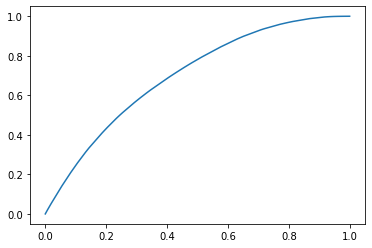

In [98]:
plt.plot(Phi, F)
plt.show()

In [49]:
import numpy as np
import matplotlib.pyplot as plt

Lc = np.float64(out[2:-1])

In [48]:
Lc

array([0.36969, 0.39434, 0.48656, 0.35775, 0.39666, 0.35629, 0.37631,
       0.40714, 0.51976, 0.40509, 0.42647, 0.50229, 0.65744, 0.38819,
       0.46035, 0.4108 , 0.30107, 0.35475, 0.32217, 0.51444, 0.48854,
       0.28145, 0.30003, 0.3194 , 0.31818, 0.48985, 0.65746, 0.34528,
       0.44821, 0.42484, 0.34226, 0.43168, 0.28213, 0.34788, 0.44405,
       0.29617, 0.71977, 0.63132, 0.62016, 0.68264, 0.63049, 0.46444,
       0.59139, 0.63447, 0.5881 , 0.59196, 0.62834, 0.78076, 0.77342,
       0.77323, 0.48429, 0.46139, 0.48068, 0.57147, 0.49656, 0.57867,
       0.47038, 0.58704, 0.62813, 0.64257, 0.78199, 0.77524, 0.68637,
       0.72538, 0.58025, 0.70117, 0.69763, 0.63174, 0.46748, 0.76795,
       0.46066, 0.5239 , 0.47362, 0.49434, 0.73015, 0.73867, 0.63465,
       0.44521, 0.47327, 0.43732, 0.40858, 0.50038, 0.49387, 0.52234,
       0.39854])

## Optimize Faulted Model program (doesn't work)

In [ ]:
# setStateFunction function is in SetFunctionGrouping
# There is difference in line 124 StateFunctionGrouping
# where the function in laptop vs mrst bitbucket is different


In [3]:
!octave -W '/content/mrst-autodiff/optimization/examples/optimizeFaultedModel.m'

/bin/bash: octave: command not found


In [31]:
!octave -W help.m

error: invalid use of script /content/addpath.m in index expression
error: called from
    help at line 2 column 1


In [23]:
!octave -W '/content/mrst-core/params/rock/makeRock.m'

In [17]:
!octave -W '/content/mrst-core/startup.m'